# **Predicting Injury Outcomes in Orange County Traffic Accidents**
## Data Science II: Group 3
### Jordan Allwood, Shivani Ananth, Meghana Mukkoti, Ava Nafisi, Rhea Nibert

## **Introduction**

Traffic accidents pose a significant public safety concern, and understanding the factors that contribute to injury outcomes is crucial for improving road safety. This project leverages machine learning techniques to predict the severity of injury a traffic accident results in based on various features recorded in accident reports.

We utilize a dataset from the Florida Department of Transportation (FDOT), which includes over 12,000 recorded accidents in Orange County from 2020. The original dataset contains more than 100 variables related to accident circumstances, such as road conditions, time of day, vehicle speed, and other contributing factors.

## **Objectives**
- Develop predictive models to classify accidents as either causing minor injuries, major injuries, fatal injuries, or no injuries.
- Identify key factors that influence injury outcomes in traffic accidents.
- Provide insights that can inform policymakers, law enforcement, and insurance companies to improve road safety and accident prevention strategies.

This Jupyter Notebook serves as a comprehensive documentation of our work, including data acquisition, data preprocessing, exploratory data analysis, feature engineering, model development, and evaluation.

In [6]:
# All imports
import os
import glob
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

ModuleNotFoundError: No module named 'gdown'

## **Data Acquisition**

We used the Florida Department of Transportation State Safety Office Geographic Information System [(SSOGis)](https://gis.fdot.gov/ssogis/) query tool to acquire our data. This tool allows you to specify queries for which to get traffic accident data. We queried the database for Orange County in 2020 to give our project a specific scope.

Since this query tool has a record limit and all data could not be returned at once, we queried for different months of 2020 and saved each data subset into a CSV file, storing the files shared Google Drive folder. The below script automates the process of acquiring and merging traffic accident data from the SSOGis. We compiled all CSVs from the shared drive folder into a Pandas DataFrame to create the base dataset.

In [4]:
# Define google share link to CSV files
folder_url = "https://drive.google.com/drive/folders/1PYLcEofxOuGAebGZJHjbZrLKetA-MnaO?usp=sharing"

# Extract folder ID from the URL
folder_id = folder_url.split('/')[-1].split('?')[0]

# Use gdown to list and download all files in the folder
!gdown --folder https://drive.google.com/drive/folders/{folder_id} -O ./csv_downloads

# Ensure the download directory exists
csv_folder = "./csv_downloads"
if not os.path.exists(csv_folder):
    os.makedirs(csv_folder)

# Find all CSV files recursively in the downloaded folder
csv_files = glob.glob(os.path.join(csv_folder, "**", "*.csv"), recursive=True)

# Read and concatenate all CSVs into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
data_v1 = pd.concat(df_list, ignore_index=True)

zsh:1: command not found: gdown


NameError: name 'pd' is not defined

Our initial dataset has 12038 rows and 126 columns.

In [ ]:
data_v1.shape

(12038, 126)

## **Data Preprocessing**

Our dataset contains many columns that will not be useful for analysis or could be combined to simplify our models. This section highlights the cleaning of our dataset to ensure it is ready for analysis.

Here are all columns in the original dataset. We'll provide an interpretation of the columns after we narrow them down to the most important predictors. Some of the columns are rather ambiguous, and we were not able to find their meaning from either the FDOT website or the metadata file. So, the interpretation is best saved for later, after we identify important variables that we can clearly identify the meaning of.

In [ ]:
list(data_v1.columns)

['Crash Id',
 'Calendar Year',
 'FDOT Crash Number',
 'Reporting Agency Case Number',
 'Reporting Agency Type',
 'FDOT Managing District',
 'County Name',
 'Crash Date',
 'Crash Time',
 'Day',
 'DHSMV City',
 'Crash Report City Code',
 'In Town',
 'On Roadway Name',
 'Int Roadway Name',
 'Reference Distance (Miles)',
 'Reference Direction',
 'Officer Latitude',
 'Officer Longitude',
 'FDOT Latitude',
 'FDOT Longitude',
 'FDOT Roadway',
 'Nearest Inventory MP',
 'Nearest Node From Crash',
 'State Road #',
 'US Highway',
 'Crash Side of Road',
 'Accident Lane Number',
 'Travel Direction Vehicle 1',
 'FDOT Road Category',
 'DHSMV Road System Id',
 'Relation to Junction',
 'Crash Harmful Event Location',
 'Intersection Type',
 'Shoulder Type',
 'FDOT Roadway SKID Test Result',
 'FDOT Roadway SKID Test Date',
 'Functional Class',
 'RCI Surface Width',
 'RCI Shoulder Type First',
 'RCI Shoulder Width First',
 'RCI Shoulder Type Second',
 'RCI Shoulder Width Second',
 'RCI Shoulder Type Third

First, we filtered the data to ensure the only year is 2020 and the county is Orange. We also removed unnecessary categorical variables. We chose which variables to keep by quickly reviewing the dataset and deciding which ones would be most useful to include in our future analyses. We removed variables that we were unable to identify a clear meaning from after performing research on the FDOT website. Also, some variable capture the same set of information, such as how "pedestrian" is included as a Crash Harmful Event and there is also a column included for whether pedestrians were involved. We removed these redundant columns. It's the same for how there is a separate solumn for many Driver Actions, such as intersection involvement, speeding, lane departure, and wrong way. We got rid of these indivdual columns and just kept the Driver Action column as to not introduce collinearity. We'll further narrow down our variable list in a future feature selection step.

In [ ]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Adjust width to prevent line breaks

data_v2 = data_v1.copy()

# Convert Crash Date to DateTime
data_v2["Crash Date"] = pd.to_datetime(data_v1["Crash Date"], format="%B %d, %Y").copy()

# Filter for 2020 and Orange County
data_v2 = data_v2[(data_v2["Crash Date"].dt.year == 2020) & (data_v2["County Name"] == "ORANGE")]

# Sort by crash date
data_v2 = data_v2.sort_values(by="Crash Date")

# List of columns to keep
columns = [
    "Crash Time", "Day", "DHSMV City", "In Town",
    "Officer Latitude", "Officer Longitude", "FDOT Latitude", "FDOT Longitude",
    "Crash Side of Road", "FDOT Road Category", "Accident Lane Number",
    "DHSMV Road System Id", "Relation to Junction", "Intersection Type",
    "Shoulder Type", "FDOT Roadway SKID Test Result", "Avg Daily Traffic",
    "Posted Speed Limit", "Alcohols/Drug Involved", "Lighting", "Weather",
    "Road Surface", "Roadway Grade", "Roadway Alignment", "Traffic Way Vehicle 1",
    "Traffic Way Vehicle 2", "Traffic Control Vehicle 1", "Traffic Control Vehicle 2",
    "Count of Lanes", "Crash Harmful Event", "Manner of Collision",
    "Vehicle Movement", "Driver Action Vehicle 1", "Driver Action Vehicle 2",
    "School Bus Related", "Count of Nonfatal Injuries", "Count of Traffic Fatalities",
    "Count of Serious Injuries", "Count of Pedestrians",
    "Count of Bicyclists", "Count of Vehicles", "Count of Persons",
    "Motorcycle Inv", "No Belt",
    "Driver - Ages Teen", "Driver - Ages 65 plus", "Driver - Ages 65-69",
    "Driver - Ages 70-74", "Driver - Ages 75-79", "Driver - Ages 80 plus"
]

# Slice DataFrame
data_v3 = data_v2[columns]

Here, we printed the different levels of all categorical variables to better understand the dataset.

In [ ]:
for col in columns:
   if not (pd.api.types.is_numeric_dtype(data_v3[col]) or pd.api.types.is_datetime64_any_dtype(data_v3[col])):
       print(f"{col}: \n")
       print(data_v3[col].unique())
       print("\n")

Day: 

['THURSDAY' 'FRIDAY' 'SATURDAY' 'SUNDAY' 'MONDAY' 'TUESDAY' 'WEDNESDAY']


DHSMV City: 

['7546 ORLANDO' '7500 UNINCORPORATED, ORANGE' '7530 APOPKA'
 '7533 ORLANDO TRANSIT AUTHORITY' '7541 OAKLAND' '7552 WINTER GARDEN'
 '7554 WINTER PARK' '7540 MAITLAND' '7542 OCOEE' '7547 CONWAY'
 '7535 EDGEWOOD' '7555 UNIV. OF CENTRAL FLORIDA' '7550 WINDERMERE'
 '7539 MOUNT DORA' '7531 BAY LAKE' '7532 BELLE ISLE' '7534 EATONVILLE'
 '7544 AZALEA PARK' '7553 LAKE BUENA VISTA']


In Town: 

['N' 'Y']


Crash Side of Road: 

['T SIDE RD LEFT' 'R RIGHT' 'L LEFT' 'S SIDE RD RIGHT' 'M MEDIAN'
 'I INTERSECTION' 'E END OF ST RD' 'U UNKNOWN']


FDOT Road Category: 

['30 URBAN 6+LN 2WY DIVD RASD' '01 INTERSTATE URBAN'
 '23 SUBURBAN 4-5LN 2WY DIVD RASD' '40 URBAN ONE WAY'
 '20 URBAN 4-5LN 2WY DIVD RASD' '26 RURAL 4-5LN 2WY DIVD RASD'
 '03 TOLL ROAD URBAN' '08 RAMP RURAL' '12 URBAN 2-3LN 2WY UNDIVD'
 '33 SUBURBAN 6+LN 2WY DIVD RASD' '21 URBAN 4-5LN 2WY DIVD PAVD'
 '07 RAMP URBAN' '04 TOLL ROAD RURAL' '24 

The categorical variables have many levels that could complicate our model, so we combined related categories. We also renamed the categories to be more readable.

Some data points have unique categories that only occur a few times throughout the dataset. To avoid creating a new level for these categories, we replaced categories that occur in less than 0.1% of the data with "Other/Unknown".

In [ ]:
data_v4 = data_v3.copy()

# Define mappings for category renaming

day_mapping = {"MONDAY": "Monday", "TUESDAY": "Tuesday",
              "WEDNESDAY": "Wednesday", "THURSDAY": "Thursday",
               "FRIDAY": "Friday", "SATURDAY": "Saturday", "SUNDAY": "Sunday"}

city_mapping = {
    '7546 ORLANDO': 'Orlando',
    '7500 UNINCORPORATED, ORANGE': 'Unincorporated Orange',
    '7530 APOPKA': 'Apopka',
    '7554 WINTER PARK': 'Winter Park',
    '7552 WINTER GARDEN': 'Winter Garden',
    '7533 ORLANDO TRANSIT AUTHORITY': 'Orlando Transit Authority',
    '7541 OAKLAND': 'Oakland',
    '7542 OCOEE': 'Ocoee',
    '7540 MAITLAND': 'Maitland',
    '7547 CONWAY': 'Conway',
    '7535 EDGEWOOD': 'Edgewood',
    '7555 UNIV. OF CENTRAL FLORIDA': 'University of Central Florida',
    '7539 MOUNT DORA': 'Mount Dora',
    '7550 WINDERMERE': 'Windermere',
    '7531 BAY LAKE': 'Bay Lake',
    '7532 BELLE ISLE': 'Belle Isle',
    '7534 EATONVILLE': 'Eatonville',
    '7544 AZALEA PARK': 'Azalea Park',
    '7553 LAKE BUENA VISTA': 'Lake Buena Vista'
}

crash_side_mapping = {
    'L LEFT': 'Left',
    'S SIDE RD RIGHT': 'Side Road Right',
    'T SIDE RD LEFT': 'Side Road Left',
    'R RIGHT': 'Right',
    'M MEDIAN': 'Median',
    'I INTERSECTION': 'Intersection',
    'E END OF ST RD': 'End of Road',
    'U UNKNOWN': 'Other/Unknown'
}

fdot_road_category_mapping = {
    '30 URBAN 6+LN 2WY DIVD RASD': 'Urban',
    '26 RURAL 4-5LN 2WY DIVD RASD': 'Rural',
    '12 URBAN 2-3LN 2WY UNDIVD': 'Urban',
    '01 INTERSTATE URBAN': 'Urban',
    '40 URBAN ONE WAY': 'Urban',
    '20 URBAN 4-5LN 2WY DIVD RASD': 'Urban',
    '23 SUBURBAN 4-5LN 2WY DIVD RASD': 'Suburban',
    '33 SUBURBAN 6+LN 2WY DIVD RASD': 'Suburban',
    '03 TOLL ROAD URBAN': 'Toll Road',
    '08 RAMP RURAL': 'Ramp',
    '21 URBAN 4-5LN 2WY DIVD PAVD': 'Urban',
    '07 RAMP URBAN': 'Ramp',
    '04 TOLL ROAD RURAL': 'Toll Road',
    '24 SUBURBAN 4-5LN 2WY DIVD PAVD': 'Suburban',
    '14 SUBURBAN 2-3LN 2WY DIVD PAVD': 'Suburban',
    '10 URBAN 2-3LN 2WY DIVD RASD': 'Urban',
    '22 URBAN 4-5LN 2WY UNDIVD': 'Urban',
    '15 SUBURBAN 2-3LN 2WY UNDIVD': 'Suburban',
    '31 URBAN 6+LN 2WY DIVD PAVD': 'Urban',
    '41 SUBURBAN ONE WAY': 'Suburban',
    '17 RURAL 2-3LN 2WY DIVD PAVD': 'Rural',
    '11 URBAN 2-3LN 2WY DIVD PAVD': 'Urban',
    '18 RURAL 2-3LN 2WY UNDIVD': 'Rural',
    '34 SUBURBAN 6+LN 2WY DIVD PAVD': 'Suburban',
    '27 RURAL 4-5LN 2WY DIVD PAVD': 'Rural'
}

accident_lane_mapping = {
    'L LEFT TURN': 'Turn',
    '1 THRU LANE 1': 'Thru Lane',
    'S SIDE OF ROAD': 'Side of Road',
    '4 THRU LANE 4': 'Thru Lane',
    '2 THRU LANE 2': 'Thru Lane',
    '3 THRU LANE 3': 'Thru Lane',
    'X RAMP': 'Ramp',
    'T CONTIN. TURN': 'Turn',
    'M MIDDLE': 'Middle',
    'D DRIVEWAY': 'Driveway',
    'R RIGHT TURN': 'Turn',
    'A ACCEL/MERGE': 'Acceleration/Merge',
    'C CROSSWALK': 'Crosswalk',
    'H ISLAND AREA': 'Island Area',
    'P PARKING': 'Parking',
    '5 THRU LANE 5': 'Thru Lane',
    'B TOLL PLAZAS': 'Toll Plazas',
    'U UNKNOWN': 'Other/Unknown',
    'V BIKE LANE': 'Bike Lane',
    '6 THRU LANE 6': 'Thru Lane',
    'E END OF ST RD': 'End of Street'
}

dhsmv_road_system_mapping = {
    '03 STATE': 'State',
    '04 COUNTY': 'County',
    '05 LOCAL': 'Local',
    '01 INTERSTATE': 'Interstate',
    '02 U.S.': 'US Route',
    '06 TURNPIKE/TOLL': 'Turnpike/Toll',
    '09 PARKING LOT': 'Parking Lot',
    '08 PRIVATE ROADWAY': 'Private Roadway',
    '77 ALL OTHER': 'Other/Unknown',
    '07 FOREST ROAD': 'Forest Road'
}

relation_to_junction_mapping = {
    '01 NON-JUNCTION': 'Non-Junction',
    '02 INTERSECTION': 'Intersection',
    '77 OTHER (SEE NARRATIVE)': 'Other/Unknown',
    '03 INTERSECTION-RELATED': 'Intersection',
    '04 DRIVEWAY/ALLEY ACCESS RELATED': 'Driveway/Alley Access Related',
    '14 ENTRANCE/EXIT RAMP': 'Entrance/Exit Ramp',
    '15 CROSSOVER-RELATED': 'Crossover-Related',
    '18 THROUGH ROADWAY': 'Through Roadway',
    '05 RAILWAY GRADE CROSSING': 'Railway Grade Crossing',
    '17 ACCELERATION/DECELERATION LANE': 'Acceleration/Deceleration Lane',
    '88 UNKNOWN': 'Other/Unknown'
}

intersection_type_mapping = {
    '01 NOT AT INTERSECTION': 'Not at Intersection',
    '02 FOUR-WAY INTERSECTION': 'Four-Way Intersection',
    '77 OTHER (SEE NARRATIVE)': 'Other/Unknown',
    '03 T-INTERSECTION': 'T-Intersection',
    '04 Y-INTERSECTION': 'Y-Intersection',
    '07 FIVE-POINT, OR MORE': 'Five-Point or More',
    '05 TRAFFIC CIRCLE': 'Traffic Circle',
    '06 ROUNDABOUT': 'Roundabout'
}

shoulder_type_mapping = {
    '03 CURB': 'Curb',
    '02 UNPAVED': 'Unpaved',
    '01 PAVED': 'Paved',
    '00 N/A': 'Not Applicable'
}

alcohols_drug_involved_mapping = {
    '0 NO': 'No Alcohol/Drugs Involved',
    '1 ALC': 'Alcohol Involved',
    '3 A/D': 'Alcohol and Drugs Involved',
    '2 DRG': 'Drugs Involved'
}

lighting_mapping = {
    '01 DAYLIGHT': 'Daylight',
    '05 DARK-NOT LIGHTED': 'Dark - Not Lighted',
    '04 DARK-LIGHTED': 'Dark - Lighted',
    '02 DUSK': 'Dusk',
    '06 DARK-UNKNOWN LIGHTING': 'Dark - Unknown Lighting',
    '03 DAWN': 'Dawn',
    '77 OTHER (EXPLAIN IN NARRATIVE)': 'Other/Unknown',
    '88 UNKNOWN': 'Other/Unknown'
}

weather_mapping = {
    '01 CLEAR': 'Clear',
    '02 CLOUDY': 'Cloudy',
    '04 FOG, SMOG, SMOKE': 'Fog, Smog, Smoke',
    '03 RAIN': 'Rain',
    '77 OTHER (SEE NARRATIVE)': 'Other/Unknown'
}

road_surface_mapping = {
    '01 DRY': 'Dry',
    '02 WET': 'Wet',
    '88 UNKNOWN': 'Other/Unknown',
    '08 WATER (STANDING/MOVING)': 'Water (Standing/Moving)',
    '06 MUD, DIRT, GRAVEL': 'Mud, Dirt, Gravel',
    '77 OTHER EXPLAIN IN NARRATIVE': 'Other/Unknown'
}

roadway_grade_mapping = {
    '00 NOT CODED': 'Other/Unknown',
    '01 LEVEL': 'Level',
    '02 HILLCREST': 'Hillcrest',
    '04 DOWNHILL': 'Downhill',
    '03 UPHILL': 'Uphill',
    '05 SAG (BOTTOM)': 'Sag (Bottom)'
}

roadway_alignment_mapping = {
    '0 NOT CODED': 'Other/Unknown',
    '1 STRAIGHT': 'Straight',
    '2 CURVE RIGHT': 'Curve Right',
    '3 CURVE LEFT': 'Curve Left'
}

traffic_way_vehicle_1_mapping = {
    'NOT CODED': 'Other/Unknown',
    'TWO-WAY, NOT DIVIDED': 'Two-Way, Not Divided',
    'TWO-WAY, DIVIDED, POSITIVE MED': 'Two-Way, Divided, Positive Median',
    'ONE-WAY TRAFFICWAY': 'One-Way Trafficway',
    'TWO-WAY, NOT DIV, W/CONT LTURN': 'Two-Way, Not Divided',
    'TWO-WAY, DIVIDED, UNPROTECTED': 'Two-Way, Divided, Unprotected',
    'UNKNOWN': 'Other/Unknown'
}

traffic_way_vehicle_2_mapping = {
    'TWO-WAY, DIVIDED, POSITIVE MED': 'Two-Way, Divided, Positive Median',
    'TWO-WAY, NOT DIVIDED': 'Two-Way, Not Divided',
    'NOT CODED': 'Other/Unknown',
    'ONE-WAY TRAFFICWAY': 'One-Way Trafficway',
    'TWO-WAY, DIVIDED, UNPROTECTED': 'Two-Way, Divided, Unprotected',
    'TWO-WAY, NOT DIV, W/CONT LTURN': 'Two-Way, Not Divided',
    'UNKNOWN': 'Other/Unknown'
}

traffic_control_vehicle_1_mapping = {
    'NOT CODED': 'Other/Unknown',
    'STOP SIGN': 'Stop Sign',
    'NO CONTROLS': 'No Controls',
    'TRAFFIC CONTROL SIGNAL': 'Traffic Control Signal',
    'YIELD SIGN': 'Yield Sign',
    'OTHER (SEE NARRATIVE)': 'Other/Unknown',
    'FLASHING SIGNAL': 'Flashing Signal',
    'UNKNOWN': 'Other/Unknown',
    'WARNING SIGN': 'Warning Sign',
    'SCHOOL ZONE SIGN/DEVICE': 'School Zone Sign/Device',
    'RAILWAY CROSSING DEVICE': 'Railway Crossing Device',
    'PERSON (INCLUDING FLAGMAN, OFF': 'Person (Including Flagman)'
}

traffic_control_vehicle_2_mapping = {
    'NO CONTROLS': 'No Controls',
    'NOT CODED': 'Other/Unknown',
    'TRAFFIC CONTROL SIGNAL': 'Traffic Control Signal',
    'STOP SIGN': 'Stop Sign',
    'YIELD SIGN': 'Yield Sign',
    'FLASHING SIGNAL': 'Flashing Signal',
    'RAILWAY CROSSING DEVICE': 'Railway Crossing Device',
    'OTHER (SEE NARRATIVE)': 'Other/Unknown',
    'PERSON (INCLUDING FLAGMAN, OFF': 'Person (Including Flagman, Off)',
    'WARNING SIGN': 'Warning Sign',
    'SCHOOL ZONE SIGN/DEVICE': 'School Zone Sign/Device',
    'UNKNOWN': 'Other/Unknown'
}

crash_harmful_event_mapping = {
    '14 MOTOR VEHICLE IN TRANSPORT': 'Motor Vehicle in Transport',
    '25 DITCH': 'Ditch',
    '38 MAILBOX': 'Mailbox',
    '15 PARKED MOTOR VEHICLE': 'Parked Motor Vehicle',
    '32 TREE (STANDING)': 'Tree (Standing)',
    '10 PEDESTRIAN': 'Pedestrian',
    '09 OTHER NON-COLLISION': 'Other Non-Collision',
    '11 PEDALCYCLE': 'Pedalcycle',
    '19 IMPACT ATTENUATOR/CRASH CUSION': 'Impact Attenuator/Crash Cushion',
    '27 GUARDRAIL FACE': 'Guardrail Face',
    '01 OVERTURN/ROLLOVER': 'Overturn/Rollover',
    '24 CURB': 'Curb',
    '05 CARGO/EQUIPMENT LOSS OR SHIFT': 'Cargo/Equipment Loss or Shift',
    '36 OTHER POST, POLE, OR SUPPORT': 'Other Post, Pole, or Support',
    '30 CONCRETE TRAFFIC BARRIER': 'Concrete Traffic Barrier',
    '33 UTILITY POLE/LIGHT SUPPORT': 'Utility Pole/Light Support',
    '16 WORK ZONE/MAINTENANCE EQUIPMEN': 'Work Zone/Maintenance Equipment',
    '17 STRUCK BY FALLING, SHIFTING CA': 'Struck by Falling, Shifting Cargo',
    '28 GUARDRAIL END': 'Guardrail End',
    '13 ANIMAL': 'Animal',
    '39 OTHER FIXED OBJECT (WALL, BUIL': 'Other Fixed Object (Wall, Building)',
    '18 OTHER NON-FIXED OBJECT': 'Other Non-Fixed Object',
    '34 TRAFFIC SIGN SUPPORT': 'Traffic Sign Support',
    '37 FENCE': 'Fence',
    '26 EMBANKMENT': 'Embankment',
    '29 CABLE BARRIER': 'Cable Barrier',
    '07 THROWN OR FALLING OBJECT': 'Thrown or Falling Object',
    '06 FELL/JUMPED FROM MOTOR VEHICLE': 'Fell/Jumped from Motor Vehicle',
    '31 OTHER TRAFFIC BARRIER': 'Other Traffic Barrier',
    '04 JACKKNIFE': 'Jackknife',
    '35 TRAFFIC SIGNAL SUPPORT': 'Traffic Signal Support',
    '08 RAN INTO WATER/CANAL': 'Ran into Water/Canal',
    '22 BRIDGE RAIL': 'Bridge Rail',
    '21 BRIDGE PIER OR SUPPORT': 'Bridge Pier or Support',
    '20 BRIDGE OVERHEAD STRUCTURE': 'Bridge Overhead Structure',
    '23 CULVERT': 'Culvert',
    '12 RAILWAY VEHICLE (TRAIN, ENGINE': 'Railway Vehicle (Train, Engine)'
}

manner_of_collision_mapping = {
    '04 SIDESWIPE, SAME DIRECTION': 'Sideswipe, Same Direction',
    '77 OTHER (SEE NARRATIVE)': 'Other/Unknown',
    '05 SIDESWIPE, OPPOSITE DIRECTION': 'Sideswipe, Opposite Direction',
    '01 FRONT TO REAR': 'Front to Rear',
    '03 ANGLE': 'Angle',
    '07 REAR TO REAR': 'Rear to Rear',
    '02 FRONT TO FRONT': 'Front to Front',
    '00 NOT CODED': 'Other/Unknown',
    '88 UNKNOWN': 'Other/Unknown',
    '06 REAR TO SIDE': 'Rear to Side'
}

vehicle_movement_mapping = {
    '00 NOT CODED': 'Other/Unknown',
    '04 BACKING': 'Backing',
    '01 STRAIGHT AHEAD': 'Straight Ahead',
    '03 TURNING LEFT': 'Turning Left',
    '11 OVERTAKING/PASSING': 'Overtaking/Passing',
    '06 CHANGING LANES': 'Changing Lanes',
    '16 LEAVING TRAFFIC LANE': 'Leaving Traffic Lane',
    '88 UNKNOWN': 'Other/Unknown',
    '77 OTHER (SEE NARRATIVE)': 'Other/Unknown',
    '05 TURNING RIGHT': 'Turning Right',
    '14 SLOWING': 'Slowing',
    '10 MAKING U-TURN': 'Making U-Turn',
    '15 NEGOTIATING A CURVE': 'Negotiating a Curve',
    '13 STOPPED IN TRAFFIC': 'Stopped in Traffic',
    '17 ENTERING TRAFFIC LANE': 'Entering Traffic Lane',
    '08 PARKED': 'Parked'
}

driver_action_vehicle_1_mapping = {
    'NOT CODED': 'Other/Unknown',
    'IMPROPER BACKING': 'Improper Backing',
    'OPERATED MV IN CARLESS OR NEGL': 'Careless or Negligent Driving',
    'RAN RED LIGHT': 'Ran Red Light',
    'FAILED TO YIELD RIGHT-OF-WAY': 'Failed to Yield Right-of-Way',
    'FOLLOWED TOO CLOSELY': 'Followed Too Closely',
    'OTHER CONTRIBUTING ACTION': 'Other Contributing Action',
    'SWERVED OR AVOIDED:  DUE TO WI': 'Swerved or Avoided',
    'FAILED TO KEEP IN PROPER LANE': 'Failed to Keep in Proper Lane',
    'NO CONTRIBUTING ACTION': 'No Contributing Action',
    'IMPROPER TURN': 'Improper Turn',
    'RAN STOP SIGN': 'Ran Stop Sign',
    'IMPROPER PASSING': 'Improper Passing',
    'RAN OFF ROADWAY': 'Ran Off Roadway',
    'OPER MV AGRSIVE, ERATIC, RCKLS': 'Aggressive or Reckless Driving',
    'DISREGARDED OTHER TRAFFIC SIGN': 'Disregarded Other Traffic Sign',
    'WRONG SIDE OF WRONG WAY': 'Wrong Side or Wrong Way',
    'OVER-CORRECTING/OVERSTEERING': 'Over-Correcting/Oversteering',
    'DROVE TOO FAST FOR CONDITIONS': 'Drove Too Fast for Conditions',
    'DISREGARDED OTHER ROAD MARKING': 'Disregarded Other Road Marking',
    'EXCEEDED POSTED SPEED': 'Exceeded Posted Speed'
}

driver_action_vehicle_2_mapping = {
    'NO CONTRIBUTING ACTION': 'No Contributing Action',
    'NOT CODED': 'Other/Unknown',
    'OTHER CONTRIBUTING ACTION': 'Other Contributing Action',
    'FAILED TO KEEP IN PROPER LANE': 'Failed to Keep in Proper Lane',
    'FOLLOWED TOO CLOSELY': 'Followed Too Closely',
    'IMPROPER BACKING': 'Improper Backing',
    'FAILED TO YIELD RIGHT-OF-WAY': 'Failed to Yield Right-of-Way',
    'IMPROPER TURN': 'Improper Turn',
    'SWERVED OR AVOIDED:  DUE TO WI': 'Swerved or Avoided',
    'OPERATED MV IN CARLESS OR NEGL': 'Careless or Negligent Driving',
    'OVER-CORRECTING/OVERSTEERING': 'Over-Correcting/Oversteering',
    'IMPROPER PASSING': 'Improper Passing',
    'WRONG SIDE OF WRONG WAY': 'Wrong Side of Wrong Way',
    'EXCEEDED POSTED SPEED': 'Exceeded Posted Speed',
    'OPER MV AGRSIVE, ERATIC, RCKLS': 'Aggressive or Reckless Driving',
    'DROVE TOO FAST FOR CONDITIONS': 'Drove Too Fast for Conditions',
    'DISREGARDED OTHER TRAFFIC SIGN': 'Disregarded Other Traffic Sign',
    'RAN RED LIGHT': 'Ran Red Light',
    'RAN OFF ROADWAY': 'Ran Off Roadway'
}

school_bus_related_mapping = {
    '01 NO': 'No',
    '03 YES, SCHOOL BUS INDIRECTLY INV': 'Yes, Indirectly Involved',
    '02 YES, SCHOOL BUS DIRECTLY INVOL': 'Yes, Directly Involved'
}

# Apply all the mappings to the dataframe
mapped = data_v3.copy()

# Dictionary of all the mappings
mappings = {
    'Day': day_mapping,
    'DHSMV City': city_mapping,
    'Crash Side of Road': crash_side_mapping,
    'FDOT Road Category': fdot_road_category_mapping,
    'Accident Lane Number': accident_lane_mapping,
    'DHSMV Road System Id': dhsmv_road_system_mapping,
    'Relation to Junction': relation_to_junction_mapping,
    'Intersection Type': intersection_type_mapping,
    'Shoulder Type': shoulder_type_mapping,
    'Alcohols/Drug Involved': alcohols_drug_involved_mapping,
    'Lighting': lighting_mapping,
    'Weather': weather_mapping,
    'Road Surface': road_surface_mapping,
    'Roadway Grade': roadway_grade_mapping,
    'Roadway Alignment': roadway_alignment_mapping,
    'Traffic Way Vehicle 1': traffic_way_vehicle_1_mapping,
    'Traffic Way Vehicle 2': traffic_way_vehicle_2_mapping,
    'Traffic Control Vehicle 1': traffic_control_vehicle_1_mapping,
    'Traffic Control Vehicle 2': traffic_control_vehicle_2_mapping,
    'Crash Harmful Event': crash_harmful_event_mapping,
    'Manner of Collision': manner_of_collision_mapping,
    'Vehicle Movement': vehicle_movement_mapping,
    'Driver Action Vehicle 1': driver_action_vehicle_1_mapping,
    'Driver Action Vehicle 2': driver_action_vehicle_2_mapping,
    'School Bus Related': school_bus_related_mapping
}

# Apply each mapping to the respective column
for column, mapping in mappings.items():
    if column in data_v4.columns:
        data_v4[column] = data_v4[column].replace(mapping)

# Filter out categories with a very small amount of records:

# List of column names
columns_to_update = [
    'DHSMV City', 'Crash Side of Road', 'FDOT Road Category', 'Accident Lane Number',
    'DHSMV Road System Id', 'Relation to Junction', 'Intersection Type', 'Shoulder Type',
    'Alcohols/Drug Involved', 'Lighting', 'Weather', 'Road Surface', 'Roadway Grade',
    'Roadway Alignment', 'Traffic Way Vehicle 1', 'Traffic Way Vehicle 2',
    'Traffic Control Vehicle 1', 'Traffic Control Vehicle 2', 'Crash Harmful Event',
    'Manner of Collision', 'Vehicle Movement', 'Driver Action Vehicle 1', 'Driver Action Vehicle 2'
]

# Loop through each column and replace small categories
for column in columns_to_update:
    counts = data_v4[column].value_counts()
    small_categories = counts[counts < 0.1/100 * data_v4.shape[0]].index
    data_v4[column] = data_v4[column].replace(small_categories, 'Other/Unknown')

# Show the cleaned data
data_v4

Crash Time       Day                 DHSMV City In Town  \
412           906  Thursday                    Orlando       N   
1649         1830  Thursday                    Orlando       N   
2132         2146  Thursday                    Orlando       N   
2131         1848  Thursday                    Orlando       N   
738            15  Thursday                    Orlando       N   
...           ...       ...                        ...     ...   
10719         912  Thursday                    Orlando       N   
10312        1901  Thursday                    Orlando       Y   
11644        1906  Thursday                   Maitland       Y   
11743        1008  Thursday  Orlando Transit Authority       N   
10071         151  Thursday                    Orlando       Y   

       Officer Latitude  Officer Longitude  FDOT Latitude  FDOT Longitude  \
412           28.428273         -81.405672      28.428185      -81.404714   
1649          28.428148         -81.404751      28.428185      -81.404714   
2132          28.374710         -81.506930      28.371287      -81.509993   
2131          28.364720         -81.515890      28.353807      -81.525668   
738           28.374160         -81.503840      28.373960      -81.503876   
...                 ...                ...            ...             ...   
10719         28.566818         -81.294318      28.566969      -81.294072   
10312          0.000000           0.000000      28.517357      -81.459137   
11644          0.000000           0.000000      28.631340      -81.387570   
11743         28.415119         -81.227595      28.413852      -81.225996   
10071          0.000000           0.000000      28.505330      -81.376250   

      Crash Side of Road FDOT Road Category Accident Lane Number  \
412       Side Road Left              Urban            Thru Lane   
1649      Side Road Left              Urban                 Turn   
2132               Right              Urban            Thru Lane   
2131               Right              Urban            Thru Lane   
738                Right              Urban            Thru Lane   
...                  ...                ...                  ...   
10719              Right              Urban            Thru Lane   
10312               Left           Suburban            Thru Lane   
11644              Right              Urban            Thru Lane   
11743              Right               Ramp                 Ramp   
10071              Right              Urban            Thru Lane   

      DHSMV Road System Id           Relation to Junction  \
412                  Local  Driveway/Alley Access Related   
1649                 Local                   Non-Junction   
2132            Interstate                   Non-Junction   
2131            Interstate                   Non-Junction   
738                  State                   Non-Junction   
...                    ...                            ...   
10719                State                   Intersection   
10312                State                   Non-Junction   
11644           Interstate                   Non-Junction   
11743        Turnpike/Toll             Entrance/Exit Ramp   
10071                State                   Non-Junction   

           Intersection Type Shoulder Type  FDOT Roadway SKID Test Result  \
412    Four-Way Intersection          Curb                             38   
1649     Not at Intersection          Curb                             38   
2132     Not at Intersection         Paved                             35   
2131     Not at Intersection         Paved                             39   
738      Not at Intersection          Curb                             31   
...                      ...           ...                            ...   
10719  Four-Way Intersection          Curb                             42   
10312    Not at Intersection         Paved                             28   
11644    Not at Intersection          Curb    

Next, we created a new column for our response variable. The categorizations are as follows:

- No injuries: 0
- Nonfatal injuries: 1
- Serious injuries: 2
- Fatalities: 3

If an accident resulted in multiple degrees of injury, we encoded it using the most severe level of classification.

In [ ]:
data_v5 = data_v4.copy()

# Create predictor column with default value at 0 (no injuries)
data_v5.insert(0, "Highest Degree of Injury", 0, True)

# In ascending order, change predictor column if at least 1 of that type of injury is present
# Resulting predictor column should only have the highest degree of injury
data_v5.loc[data_v5["Count of Nonfatal Injuries"] > 0, "Highest Degree of Injury"] = 1
data_v5.loc[data_v5["Count of Serious Injuries"] > 0, "Highest Degree of Injury"] = 2
data_v5.loc[data_v5["Count of Traffic Fatalities"] > 0, "Highest Degree of Injury"] = 3

# Drop previous injury count columns
data_v5.drop(columns=["Count of Nonfatal Injuries", "Count of Serious Injuries", "Count of Traffic Fatalities"], inplace=True)

Then, we observed which columns contained null values to help decide how to handle this - whether we should remove the entire column, remove the null rows, or use a more advanced imputation strategy. We also looked at the data type of each column to see which imputation stategy would be best.

In [ ]:
pd.DataFrame({
    "Nulls": data_v5.isnull().sum(),
    "Dtype": data_v5.dtypes
})

Nulls    Dtype
Highest Degree of Injury           0    int64
Crash Time                         0    int64
Day                                0   object
DHSMV City                         0   object
In Town                            0   object
Officer Latitude                   0  float64
Officer Longitude                  0  float64
FDOT Latitude                      0  float64
FDOT Longitude                     0  float64
Crash Side of Road                 0   object
FDOT Road Category               126   object
Accident Lane Number               0   object
DHSMV Road System Id               0   object
Relation to Junction               0   object
Intersection Type                  0   object
Shoulder Type                      0   object
FDOT Roadway SKID Test Result      0    int64
Avg Daily Traffic                136  float64
Posted Speed Limit              1174  float64
Alcohols/Drug Involved             0   object
Lighting                           0   object
Weather                            0   object
Road Surface                       0   object
Roadway Grade                      0   object
Roadway Alignment                  0   object
Traffic Way Vehicle 1             51   object
Traffic Way Vehicle 2           2151   object
Traffic Control Vehicle 1          0   object
Traffic Control Vehicle 2          0   object
Count of Lanes                   134  float64
Crash Harmful Event                0   object
Manner of Collision                0   object
Vehicle Movement                   0   object
Driver Action Vehicle 1            0   object
Driver Action Vehicle 2            0   object
School Bus Related                 0   object
Count of Pedestrians               0    int64
Count of Bicyclists                0    int64
Count of Vehicles                  0    int64
Count of Persons                   0    int64
Motorcycle Inv                     0   object
No Belt                            0   object
Driver - Ages Teen                 0   object
Driver - Ages 65 plus              0   object
Driver - Ages 65-69                0   object
Driver - Ages 70-74                0   object
Driver - Ages 75-79                0   object
Driver - Ages 80 plus              0   object

The above table shows the null count in each column of the dataset. Since the affected columns have different data types, we examined each one individually and applied appropriate imputation strategies:

- **FDOT Road Category**: Since this is a categorical variable, we replaced missing values with "Other/Unknown" to maintain consistency without introducing bias.
- **Avg Daily Traffic**: This numerical variable was imputed using the mean, as it best preserves the distribution of traffic data.
- **Posted Speed Limit**: Since this is a discrete varaible, we imputed it with the median instead of the mean.
- **Traffic Way Vehicle 1 & Traffic Way Vehicle 2**: Replaces missing values with "Other/Unknown"
- **Count of Lanes**: Since this is a discrete numeric variable, we used the median for imputation, ensuring we don’t introduce skewness from extreme values.
- **Longitude/Latitude Variables**: We noticed from inspecting the data that many of these columns have a value of 0, meaning the coordinates weren't recorded for these accidents. After calculating that there were 5045 rows with at least one missing coordinate (nearly half the dataset), we decided to drop these columns.
- **FDOT Roadway SKID Test Result**: This column also contains some zero values. After finding that only 1187 are missing, which is around 10%, we decided to impute these values with the median.

In [ ]:
data_v6 = data_v5.copy()

# Impute FDOT Road Category with "Other/Unknown"
data_v6["FDOT Road Category"] = data_v6["FDOT Road Category"].fillna("Other/Unknown")

# Impute Traffic Control Vehicle 1 & 2 with "Other/Unknown"
data_v6["Traffic Way Vehicle 1"] = data_v6["Traffic Way Vehicle 1"].fillna("Other/Unknown")
data_v6["Traffic Way Vehicle 2"] = data_v6["Traffic Way Vehicle 2"].fillna("Other/Unknown")

# Impute numerical columns with specified strategies
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

data_v6["Avg Daily Traffic"] = mean_imputer.fit_transform(data_v6[["Avg Daily Traffic"]])
data_v6["Posted Speed Limit"] = median_imputer.fit_transform(data_v6[["Posted Speed Limit"]])
data_v6["Count of Lanes"] = median_imputer.fit_transform(data_v6[["Count of Lanes"]])

# List of longitude and latitude columns to check for 0 values
coordinate_columns = [
    'FDOT Longitude',
    'FDOT Latitude',
    'Officer Longitude',
    'Officer Latitude',
]

# Create a boolean mask indicating rows with at least one zero in the specified columns
has_zero = (data_v6[coordinate_columns] == 0).any(axis=1)

# Count the number of True values in the boolean mask
rows_with_zero = has_zero.sum()

print("Number of rows with at least one zero value in the longitude/latitude columns:", rows_with_zero)

# Drop these columns since nearly half have the value 0
data_v6 = data_v6.drop(columns=["FDOT Longitude", "FDOT Latitude", "Officer Latitude", "Officer Longitude"])

# Check for 0s in skid test column
print(f'Number of rows with zero values in skid test column: {(data_v6["FDOT Roadway SKID Test Result"] == 0).sum()}')

# Compute the median of FDOT Roadway SKID Test Result excluding zeros
skid_test_mean = data_v6.loc[data_v5["FDOT Roadway SKID Test Result"] > 0, "FDOT Roadway SKID Test Result"].median()

# Replace zero values with the computed median
data_v6.loc[data_v6["FDOT Roadway SKID Test Result"] == 0, "FDOT Roadway SKID Test Result"] = skid_test_mean

# Ensure no nulls remain
print(f"Are there null values?: {data_v6.isnull().values.any()}")

Number of rows with at least one zero value in the longitude/latitude columns: 5045
Number of rows with zero values in skid test column: 1187
Are there null values?: False


## **Feature Selection**

In this analysis, we aimed to identify the most important features for predicting injury severity using the dataset. We chose to start with 20 features since this is a more manageable number than 50+. Initially, we considered using `SelectKBest` for feature selection, but we realized that this method is more tailored toward either categorical or continuous data, not both. Our dataset contains a mix of both types, so we decided to explore alternative methods.

We switched to `RandomForestClassifier` because it can handle both categorical and continuous variables effectively. Random forests also provide built-in feature importance, which allows us to directly assess the relevance of each feature for the prediction task. This made it a suitable choice for our needs.

While we also considered using `RFE` (Recursive Feature Elimination) for feature selection, we encountered performance issues due to the size of our dataset. The `RFE` process was taking too long to complete, especially given the large number of features we had. As a result, we decided to use RandomForestClassifier and adjusted the model’s parameters to optimize performance.

To extract the most relevant features, we initially ranked all transformed features by importance. However, because categorical variables were one-hot encoded, multiple levels of the same categorical variable often appeared in the top rankings. Instead of selecting multiple levels of the same categorical variable, we modified our approach to ensure that only one categorical variable was selected if at least one of its levels appeared in the top rankings. This ensures that we focus on 20 distinct features from the original dataset, rather than being overly biased toward a single categorical variable with many high-importance levels.

Additionally, we included the original feature index in the final `DataFrame`. This is useful for future steps, as it allows us to trace back which features were selected from the raw dataset,

In [ ]:
# Set input and output variables
X = data_v6.drop(columns='Highest Degree of Injury')
y = data_v6['Highest Degree of Injury']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing for numeric features (Scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features (OneHotEncoding)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop="first", sparse_output=False))
])

# Combine both transformations into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Create a pipeline that first preprocesses and then trains the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Fit the pipeline
pipeline.fit(X, y)

# Get feature importances from the trained RandomForestClassifier
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Get feature names after transformation
transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract base column names from transformed feature names
adjusted_feature_names = []
original_feature_names = []
for name in transformed_feature_names:
    clean_name = name.split('__')[-1].split('_')[0]  # Extract original feature name
    adjusted_feature_names.append(clean_name)
    original_feature_names.append(clean_name)

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Select top 20 unique features
k = 20
selected_features = []
selected_importances = []
selected_original_features = set()

for i in sorted_indices:
    original_feature = original_feature_names[i]
    if original_feature not in selected_original_features:
        selected_original_features.add(original_feature)
        selected_features.append(adjusted_feature_names[i])
        selected_importances.append(feature_importances[i])
    if len(selected_features) == k:
        break

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': selected_features,
    'Importance': selected_importances
})

# Display the DataFrame
feature_importance_df

Feature Name  Importance
0                      Crash Time    0.078766
1               Avg Daily Traffic    0.063685
2   FDOT Roadway SKID Test Result    0.046404
3                Count of Persons    0.042098
4              Posted Speed Limit    0.030118
5                  Count of Lanes    0.027812
6         Driver Action Vehicle 1    0.015111
7              Crash Side of Road    0.014535
8                        Lighting    0.014430
9               Count of Vehicles    0.014375
10            Manner of Collision    0.013440
11           DHSMV Road System Id    0.012343
12                  Shoulder Type    0.011950
13                     DHSMV City    0.011784
14                            Day    0.011711
15                        In Town    0.011655
16                        Weather    0.010767
17               Vehicle Movement    0.010087
18                   Road Surface    0.009970
19             Driver - Ages Teen    0.009648

Now that we have narrowed down our features, we can provide a clear interpretation of each one, which will make our visualizations and model easier to understand:

NEEDS TO BE DONE

## **Data Visualization**

Now that we have our top features, we can create visualizations targeted toward these top features. We chose the most effective type of visualization based on the variable type (continuous, discrete, categorical, geospatial). The first goal of our visualization is identifying any patterns in variable distribution between the different degrees of injury. This will help us see visually which variables are most important. If there is a signficant variation of values between different injury classes, this suggests this variable will be a powerful predictor.

In [ ]:
# Set a custom color pallete for visualizations
custom_palette = {0: "#A8D08D", 1: "#FFD966", 2: "#FF8C42", 3: "#D84B16"}

# Define selected variables
continuous_vars = [
    "Crash Time", "Avg Daily Traffic"
]

discrete_vars = [
    "Count of Persons", "Posted Speed Limit", "Count of Lanes",
    "Count of Vehicles", "FDOT Roadway SKID Test Result"
]

categorical_vars = [
    "Driver Action Vehicle 1", "Crash Side of Road", "Manner of Collision",
    "Lighting", "DHSMV City", "DHSMV Road System Id", "In Town",
    "Vehicle Movement", "Weather", "Shoulder Type", "Road Surface", "Day",
    "Driver - Ages Teen"
]

### **Box Plots**

We began by creating box plots of our continuous numeric features to visualize the distrubition of values among the injury classes. Box plots are best suited for continuous variables.

Based on these plots, the distribtion of the continuous variables `Crash Time` and `Avg Daily Traffic` seem to be relatively consistent among the injury classes, showing no obvious patterns.

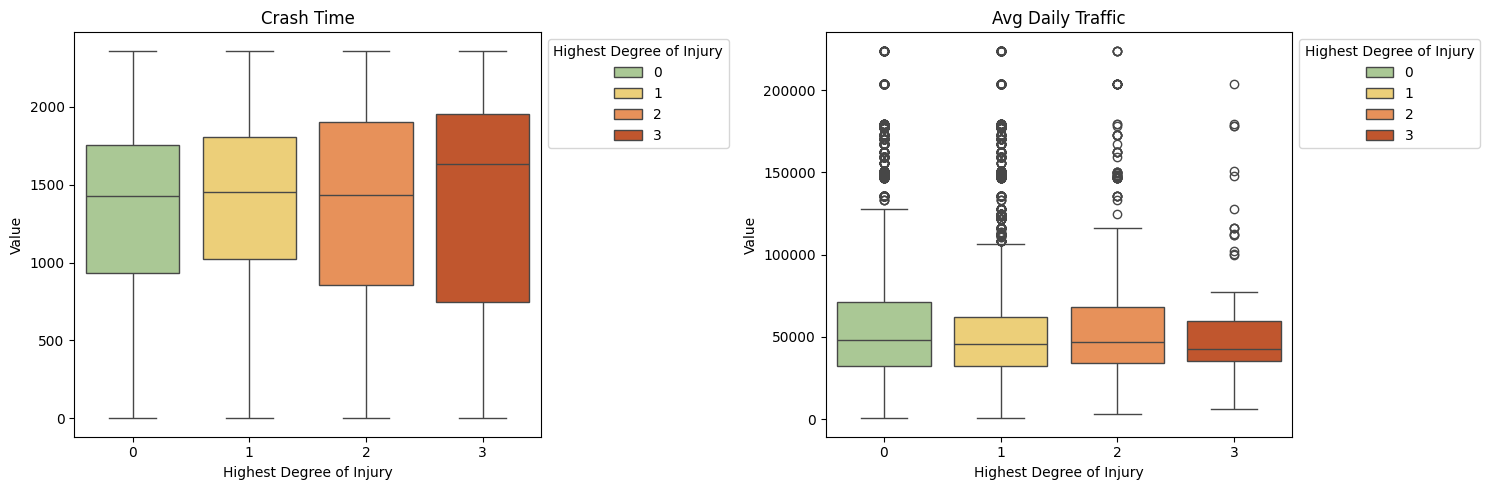

In [ ]:
# Set figure size
plt.figure(figsize=(15, 5))

# Create subplots for each numeric feature
for i, feature in enumerate(continuous_vars, 1):
    plt.subplot(1, 2, i)  # 1 row, 2 columns layout
    sns.boxplot(x="Highest Degree of Injury",
                y=feature,
                data=data_v6,
                palette=custom_palette,
                hue="Highest Degree of Injury")
    plt.title(feature)
    plt.xlabel("Highest Degree of Injury")
    plt.ylabel("Value")
    plt.legend(title="Highest Degree of Injury", bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.show()

### **Bar Charts**

Bar charts are more effective than box plots for conveying information about discrete variables. In these bar charts, we explored the same goal: investigating the distribution of values among the injury classes.

 INTERPRET

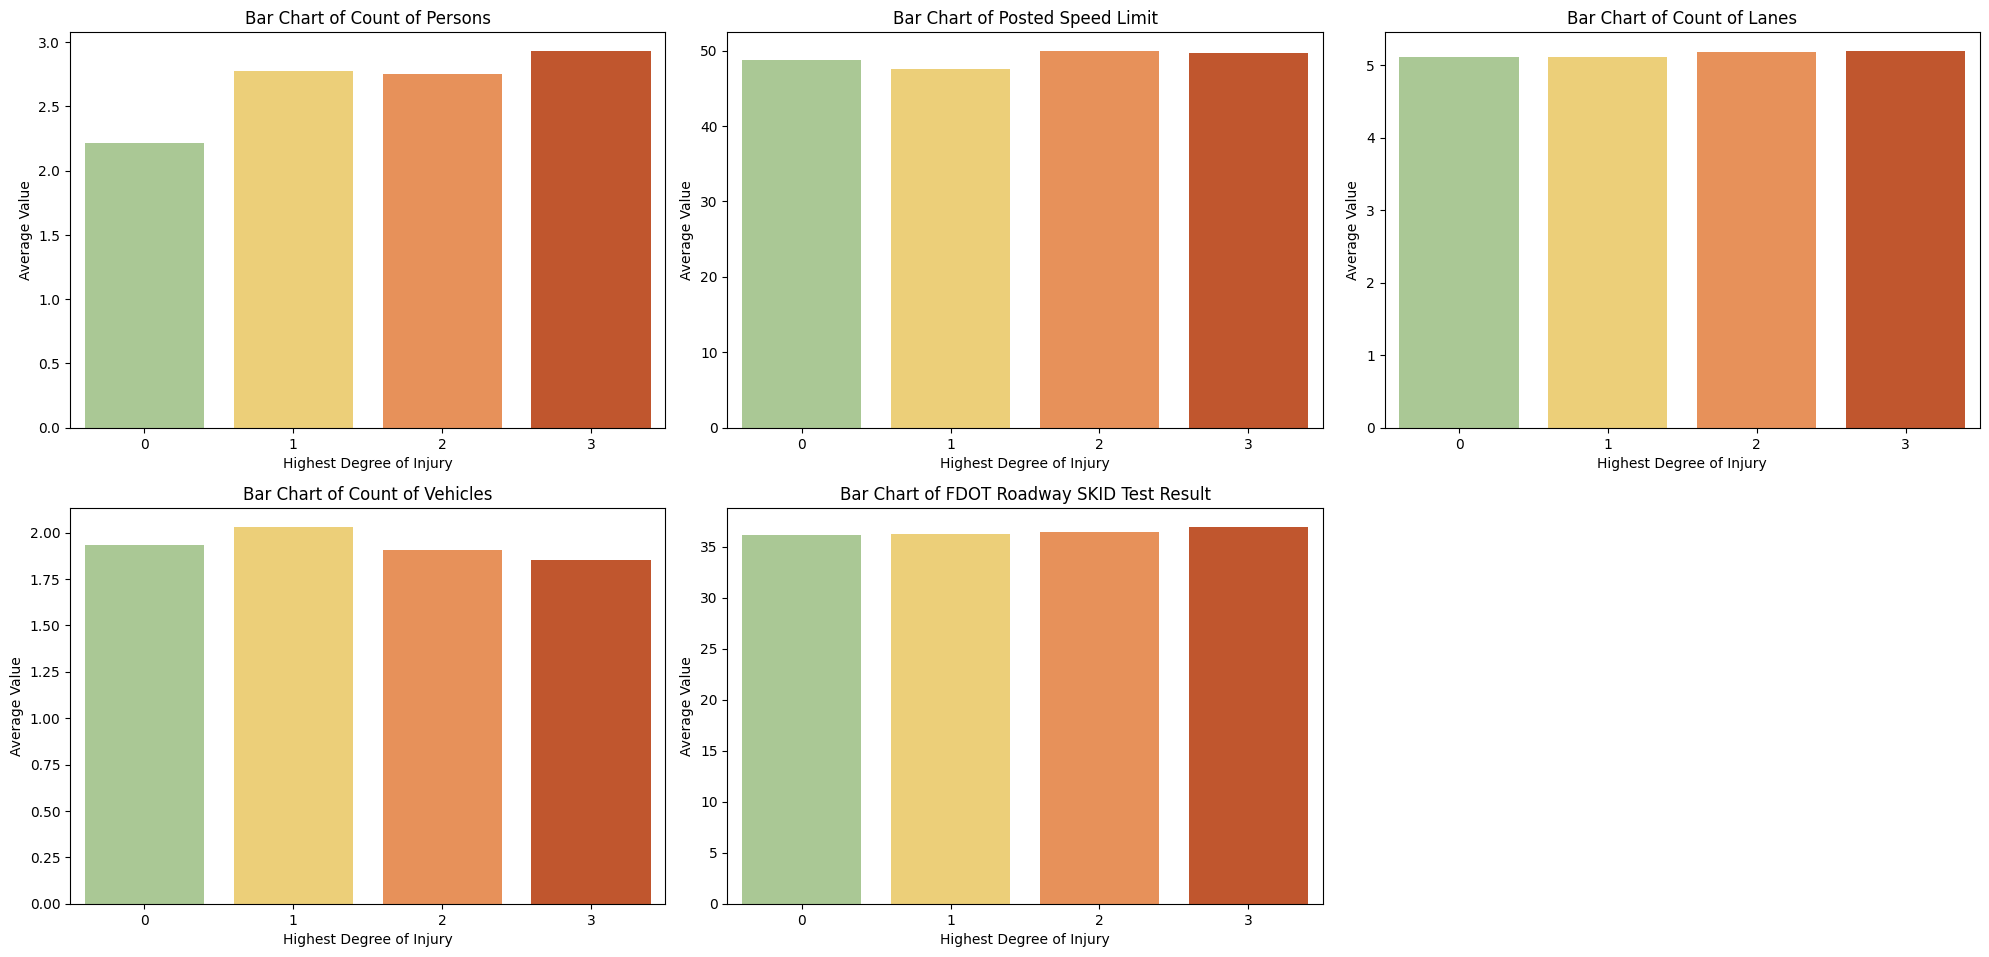

In [ ]:
# Set figure size for discrete variables (in a grid)
plt.figure(figsize=(20, 14))

# Create bar charts for discrete variables
for i, feature in enumerate(discrete_vars, 1):
    plt.subplot(3, 3, i)  # 3 rows, 3 columns layout for discrete variables
    sns.barplot(x="Highest Degree of Injury",
                y=feature, data=data_v6,
                palette=custom_palette,
                hue="Highest Degree of Injury",
                errorbar=None,
                legend=False)
    plt.title(f"Bar Chart of {feature}")
    plt.xlabel("Highest Degree of Injury")
    plt.ylabel("Average Value")

plt.tight_layout()
plt.show()

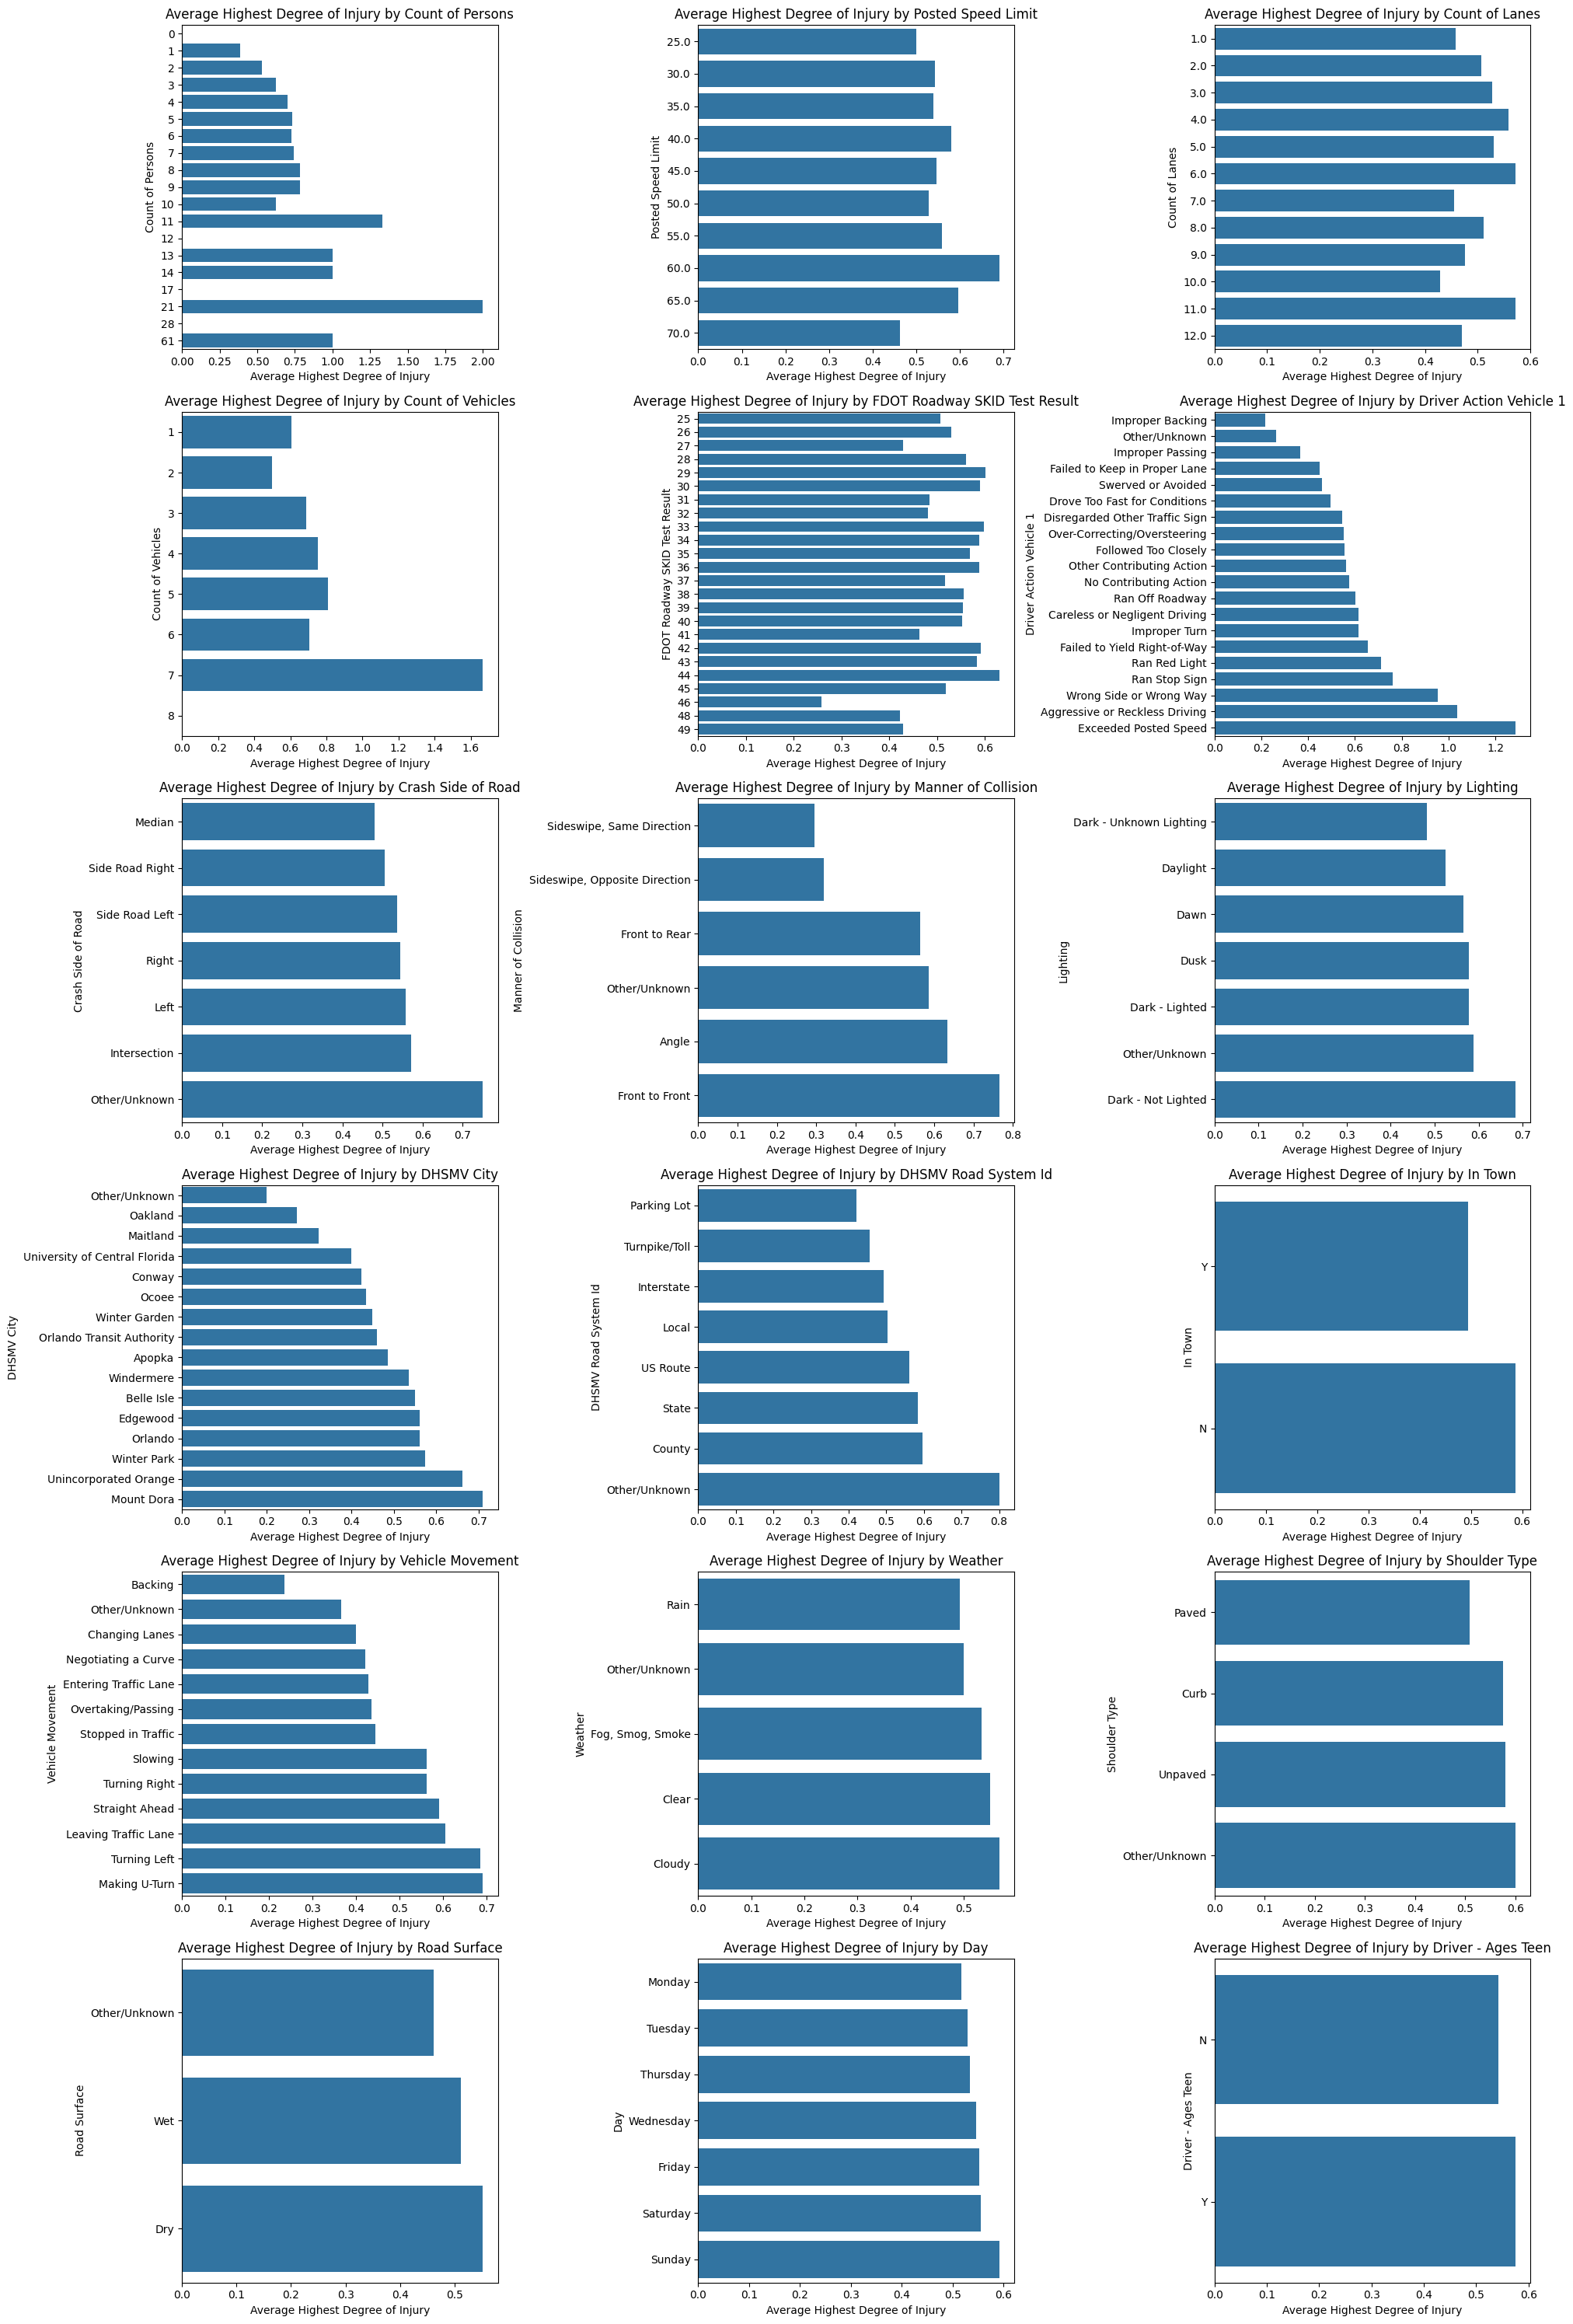

In [ ]:
vars_to_plot = discrete_vars + categorical_vars

# Set figure size
plt.figure(figsize=(20, 30))

# Create horizontal bar charts
for i, feature in enumerate(vars_to_plot, 1):
    plt.subplot(6, 3, i)

    # Calculate the average 'Highest Degree of Injury' for each level of variables
    average_injury = data_v6.groupby(feature)['Highest Degree of Injury'].mean().sort_values()

    sns.barplot(y=average_injury.index, x=average_injury.values, orient="h")
    plt.title(f"Average Highest Degree of Injury by {feature}")
    plt.xlabel("Average Highest Degree of Injury")
    plt.ylabel(feature)
    plt.yticks(rotation=0)  # Ensure y-axis labels remain readable

plt.tight_layout()
plt.show()

### **Stacked Bar Charts**

Stacked bar charts are better suited for categorical variables because they show a part-to-whole relationship, or what proportion of each injury level occurs in each level of the categorical variables. Looking at the below plots, here are some insights:

FIX FIX FIX NOT DONE


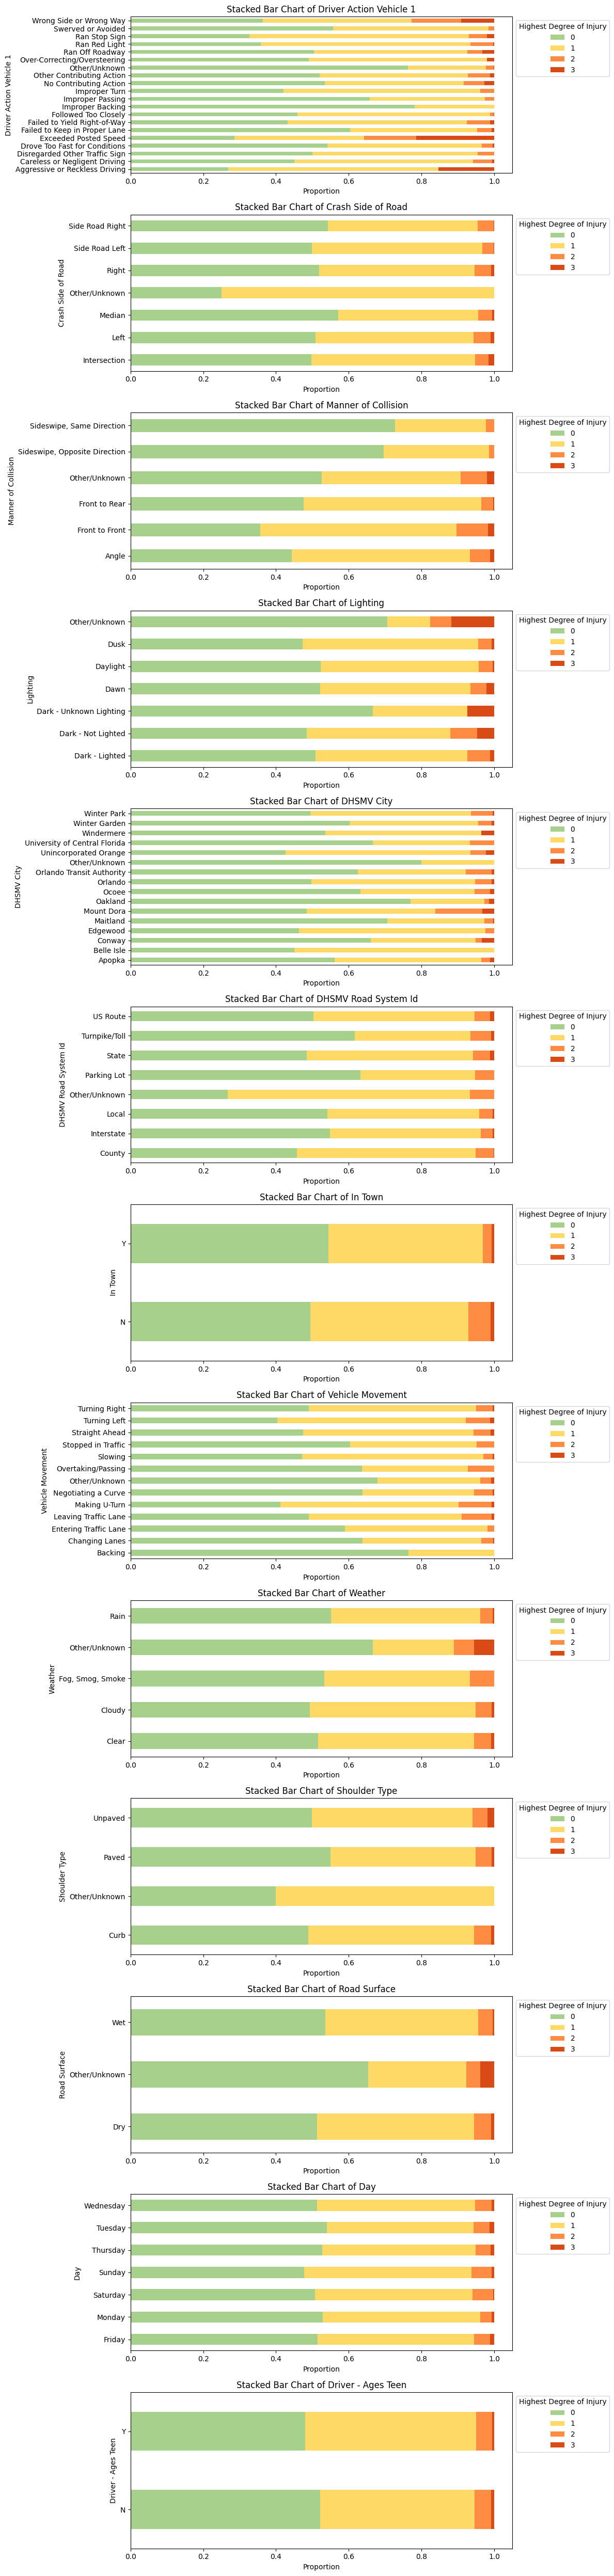

In [ ]:
# Set figure size
plt.figure(figsize=(12, 50))

# Create stacked horizontal bar charts
for i, feature in enumerate(categorical_vars, 1):
    plt.subplot(len(categorical_vars), 1, i)

    # Compute proportions
    cross_tab = pd.crosstab(data_v6[feature], data_v6["Highest Degree of Injury"], normalize="index")

    # Get colors in order of the categories in "Highest Degree of Injury"
    injury_levels = cross_tab.columns
    colors = [custom_palette[level] for level in injury_levels]

    cross_tab.plot(kind="barh", stacked=True, color=colors, ax=plt.gca())

    plt.title(f"Stacked Bar Chart of {feature}")
    plt.ylabel(feature)
    plt.xlabel("Proportion")
    plt.legend(title="Highest Degree of Injury", bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.show()

### **Swarm/Strip Plots**

Due to the dataset being too large to be properly represented in swarm plots, we'll sample only 2000 entires to get an broad look at our data.


AVA: take out dodge=true if you don't want the colors to be separated, i just thought it made it easier to see the different classes

also, there were warnings about all points not fitting, so for the discrete and continuous variables where all the points are stacked i switched to strip plot


INTERPRET - NOT DONE

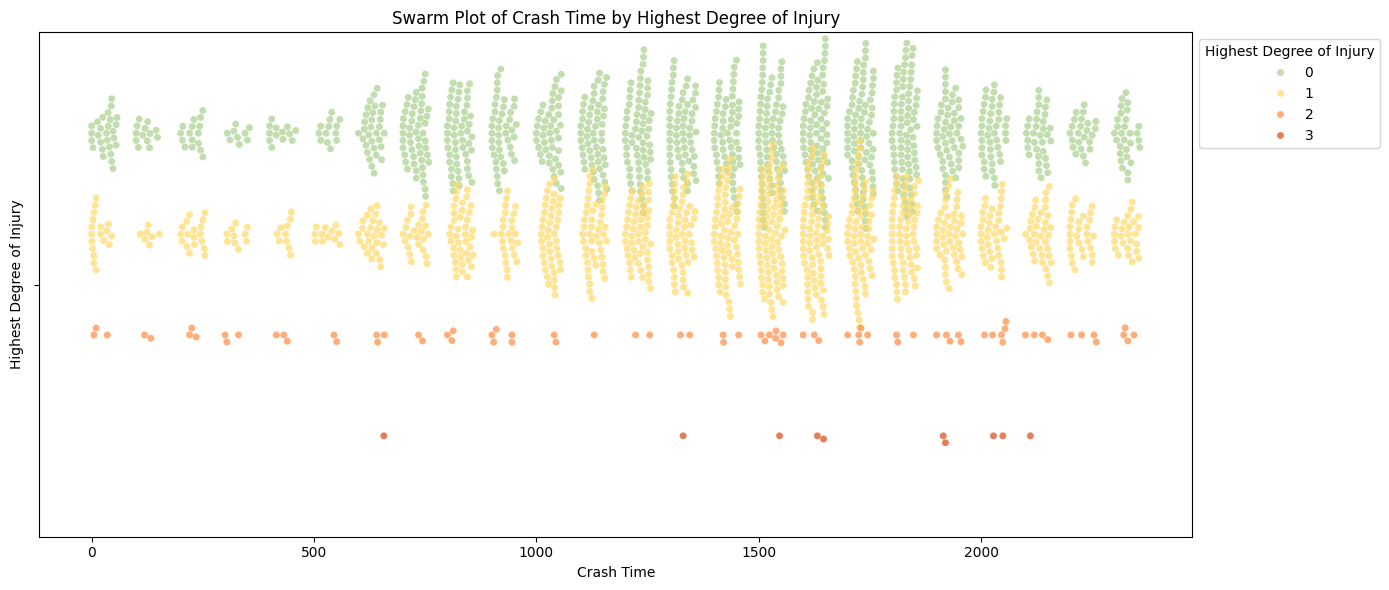

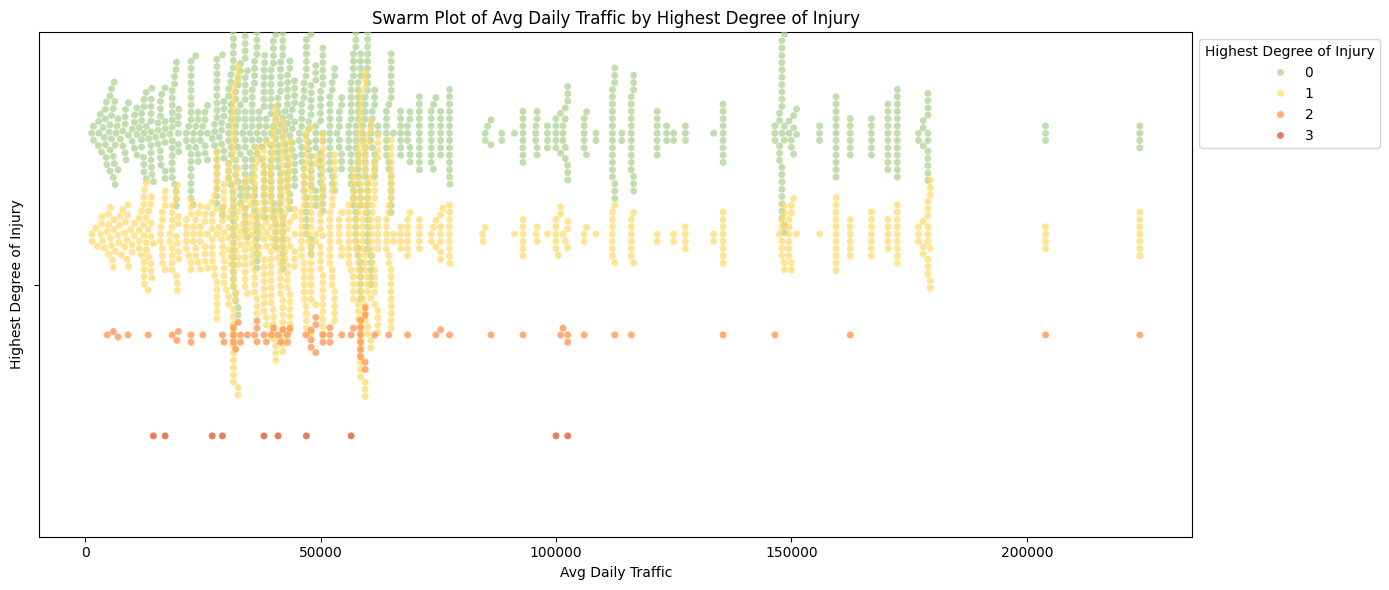

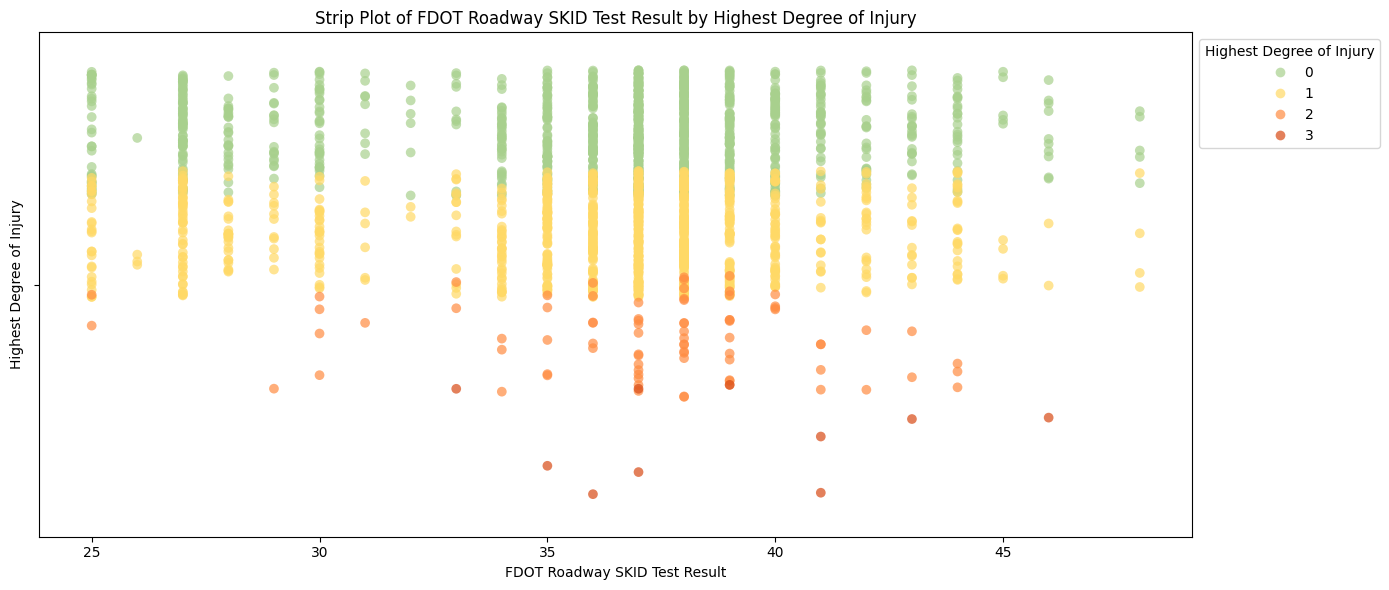

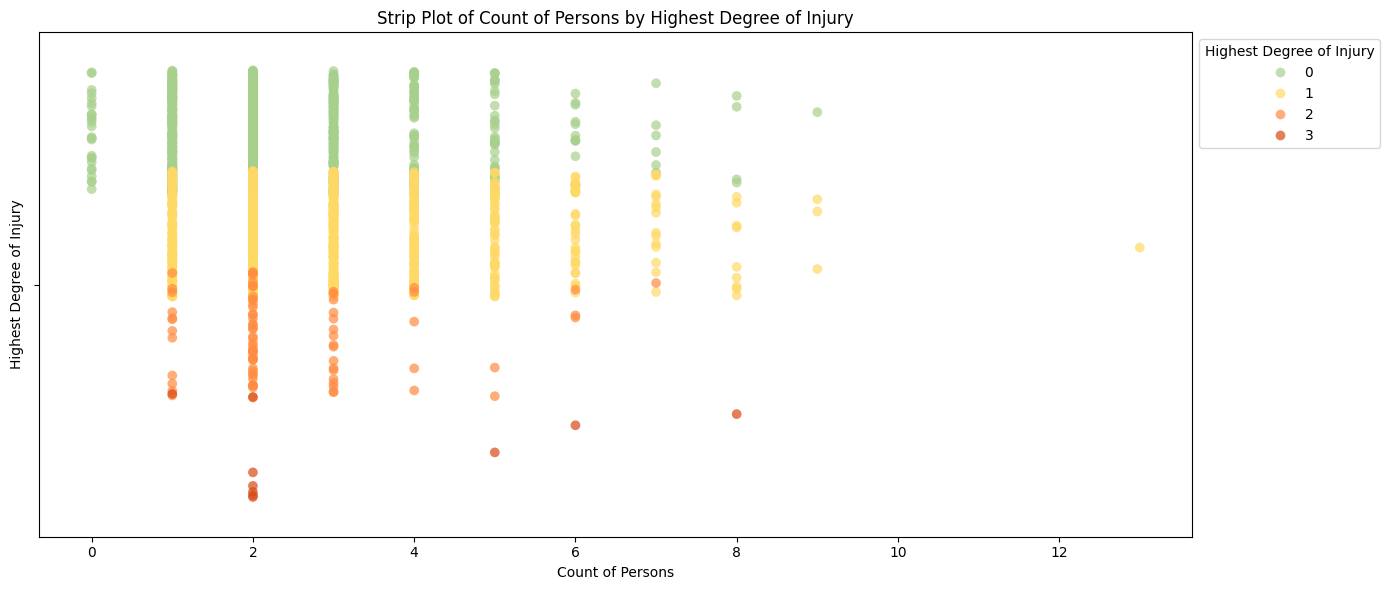

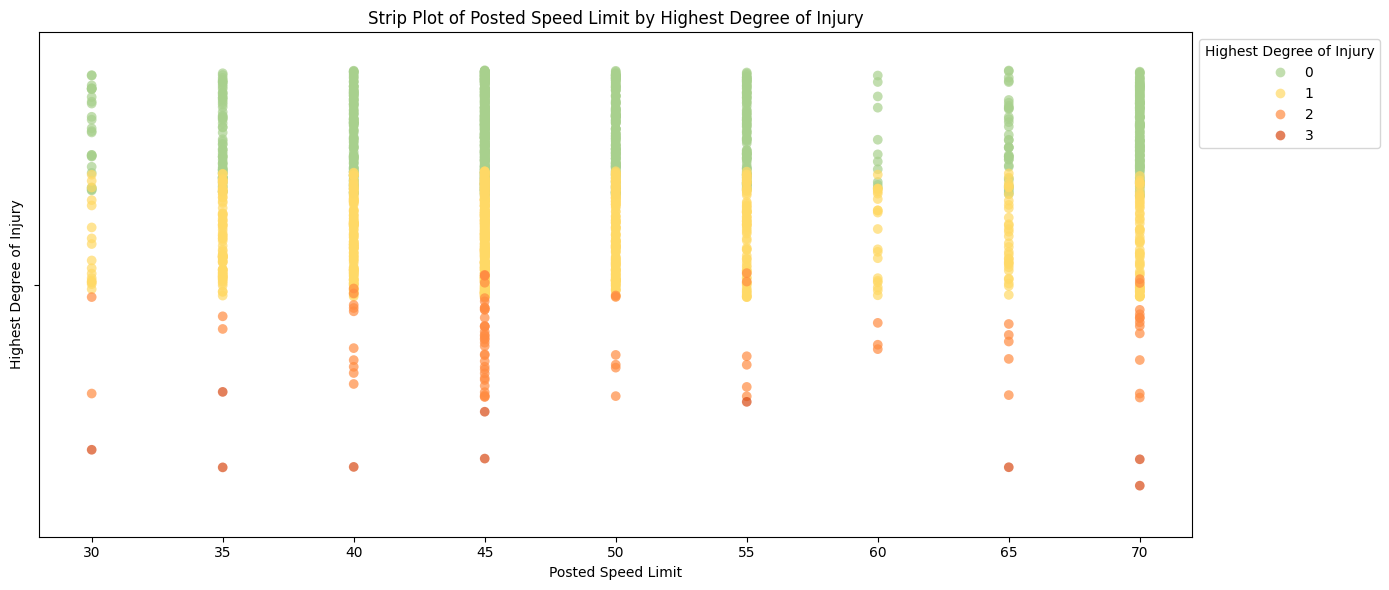

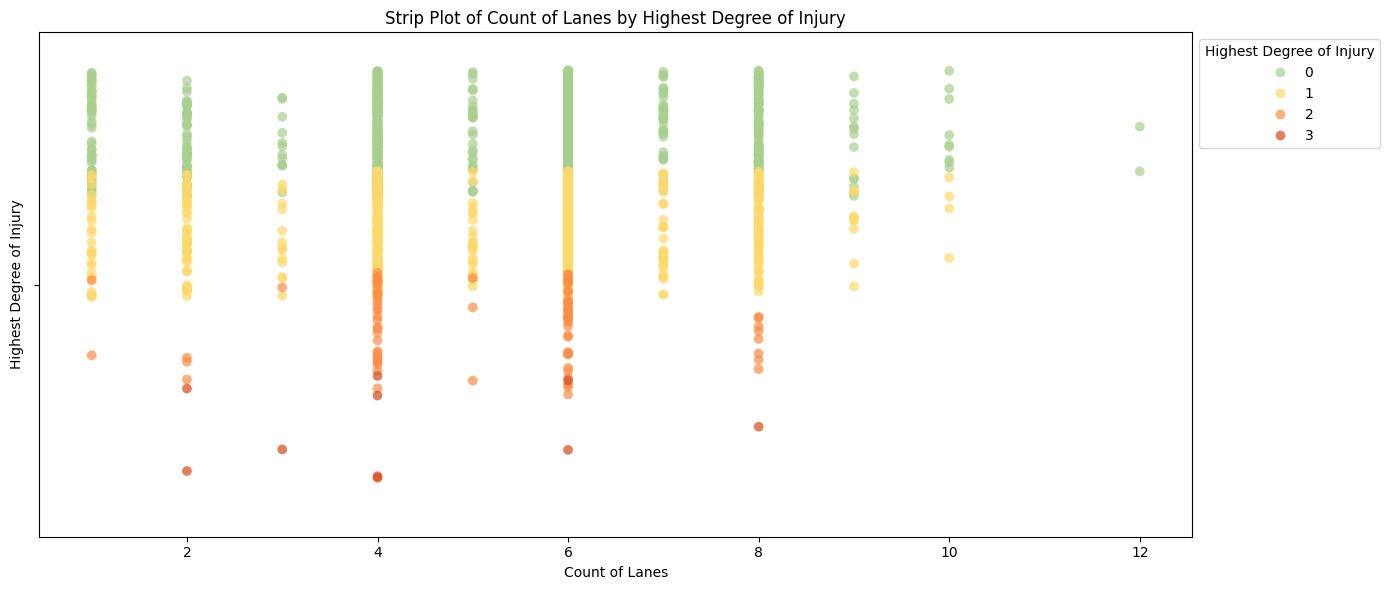

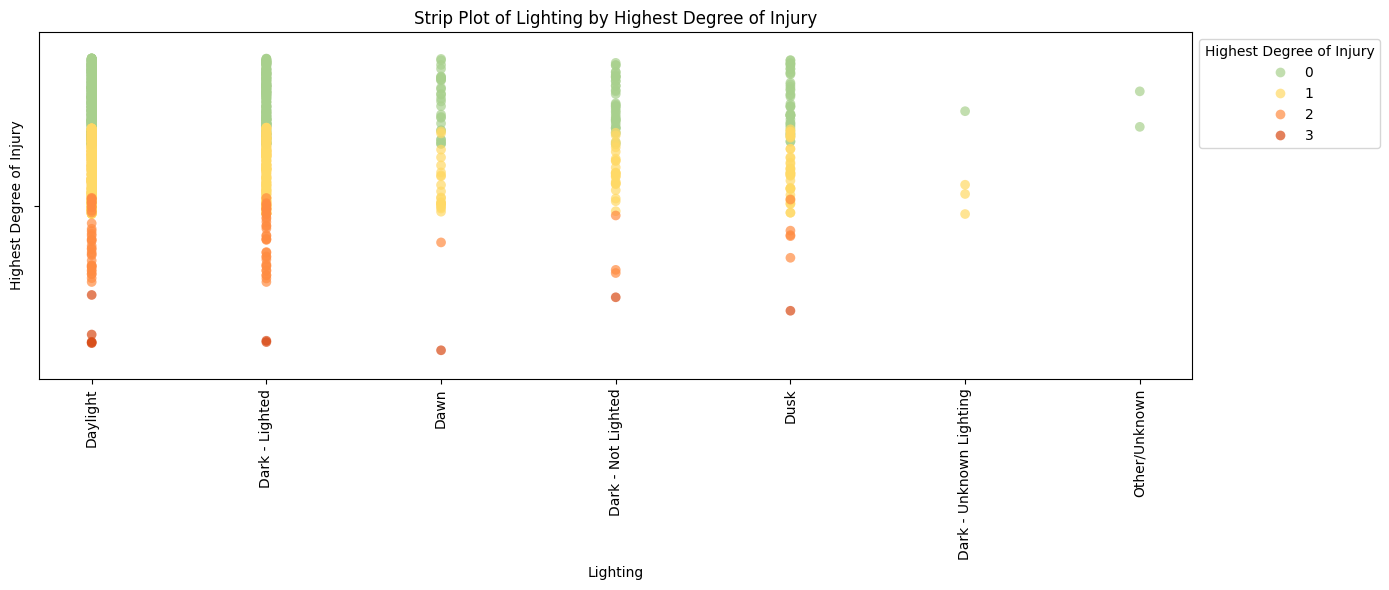

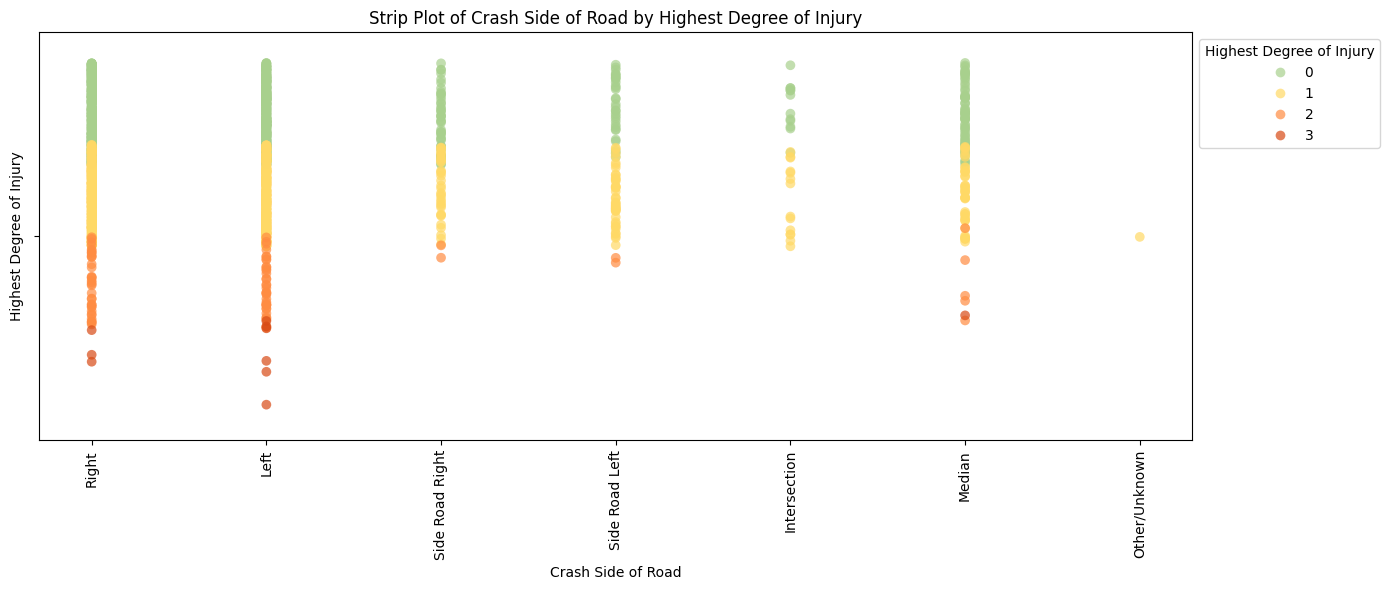

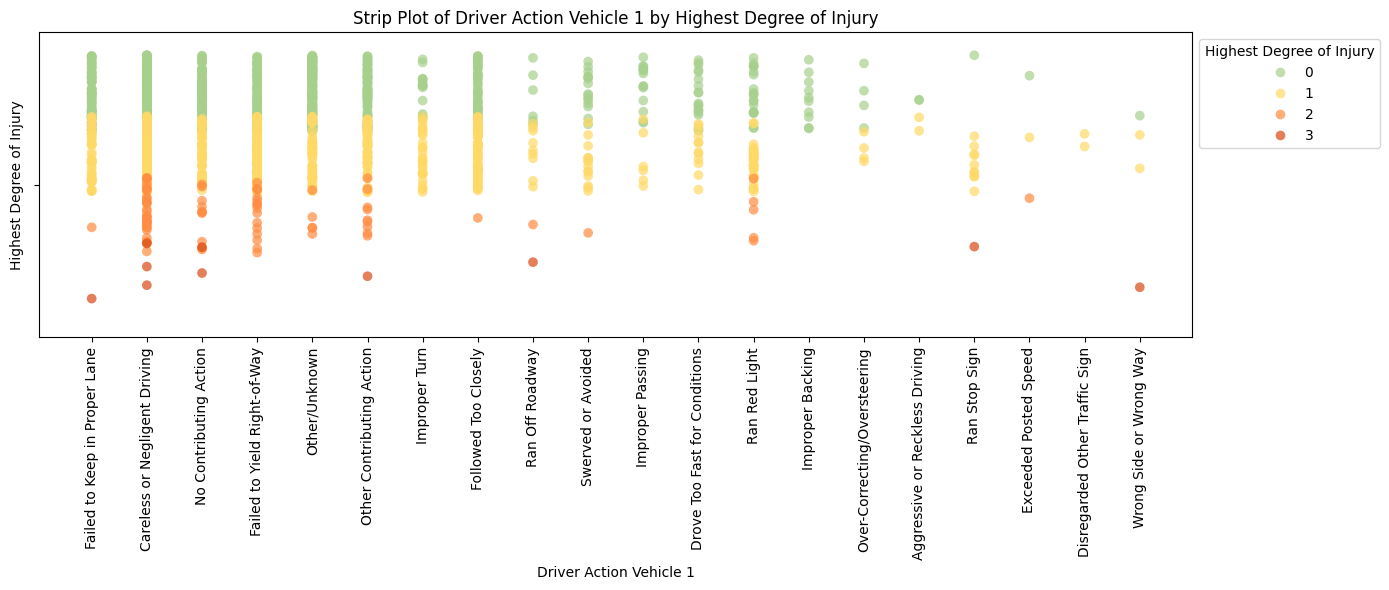

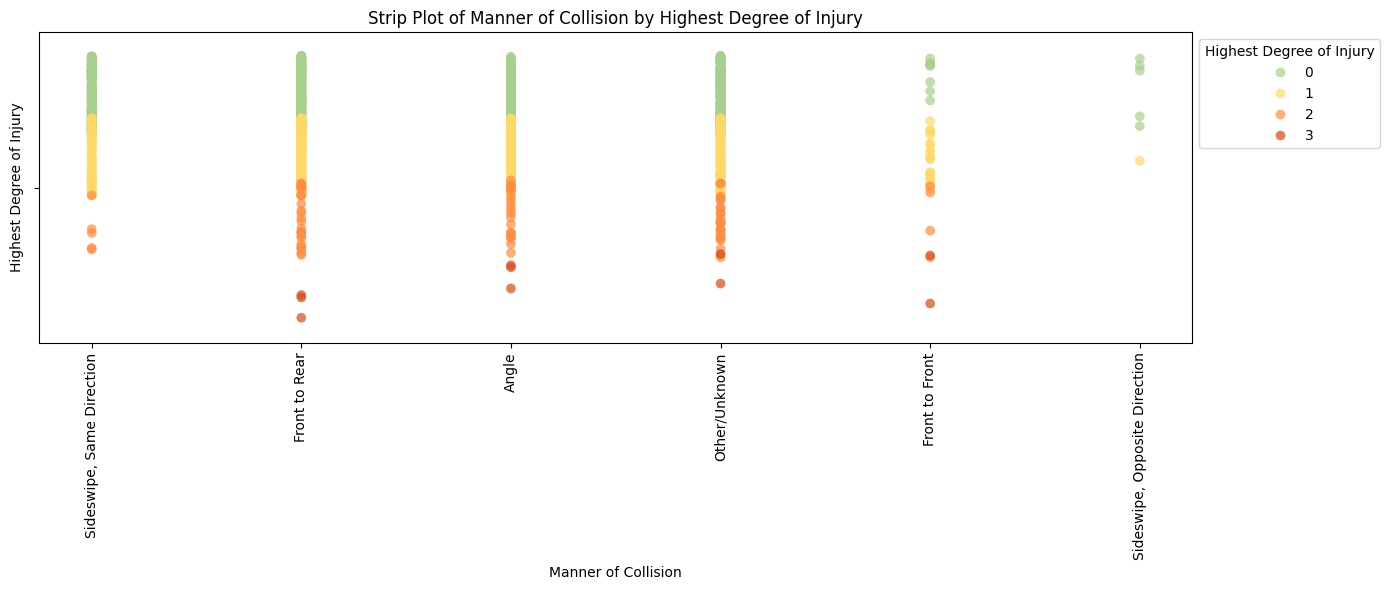

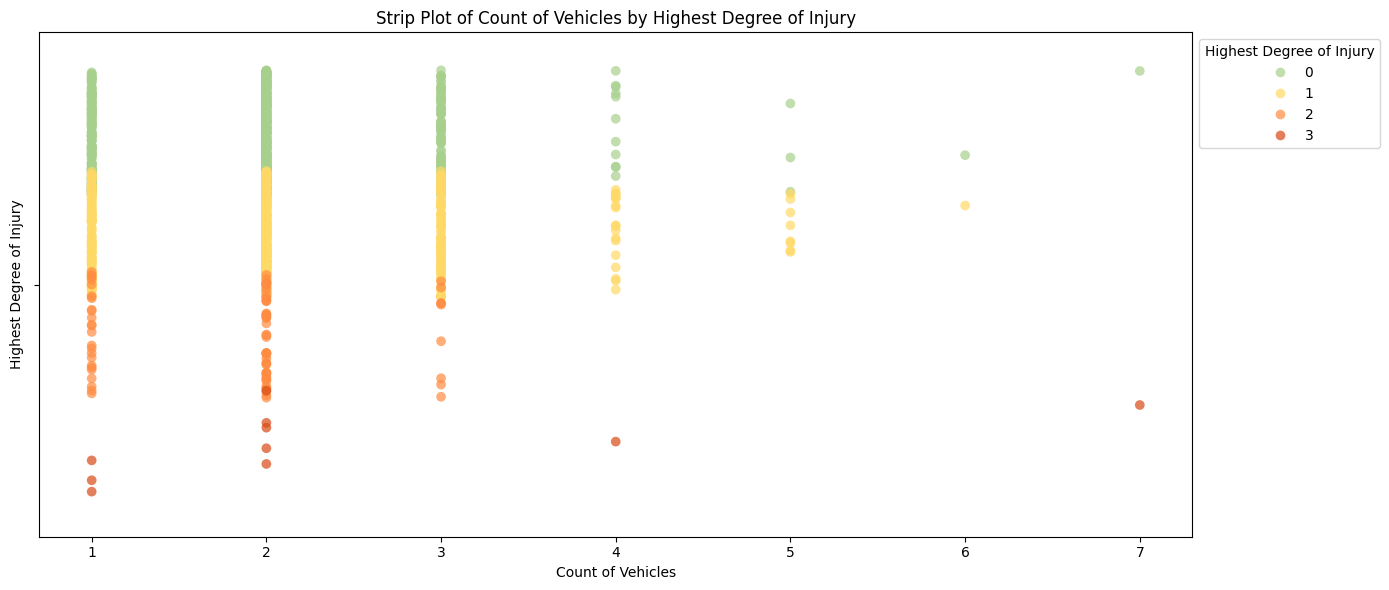

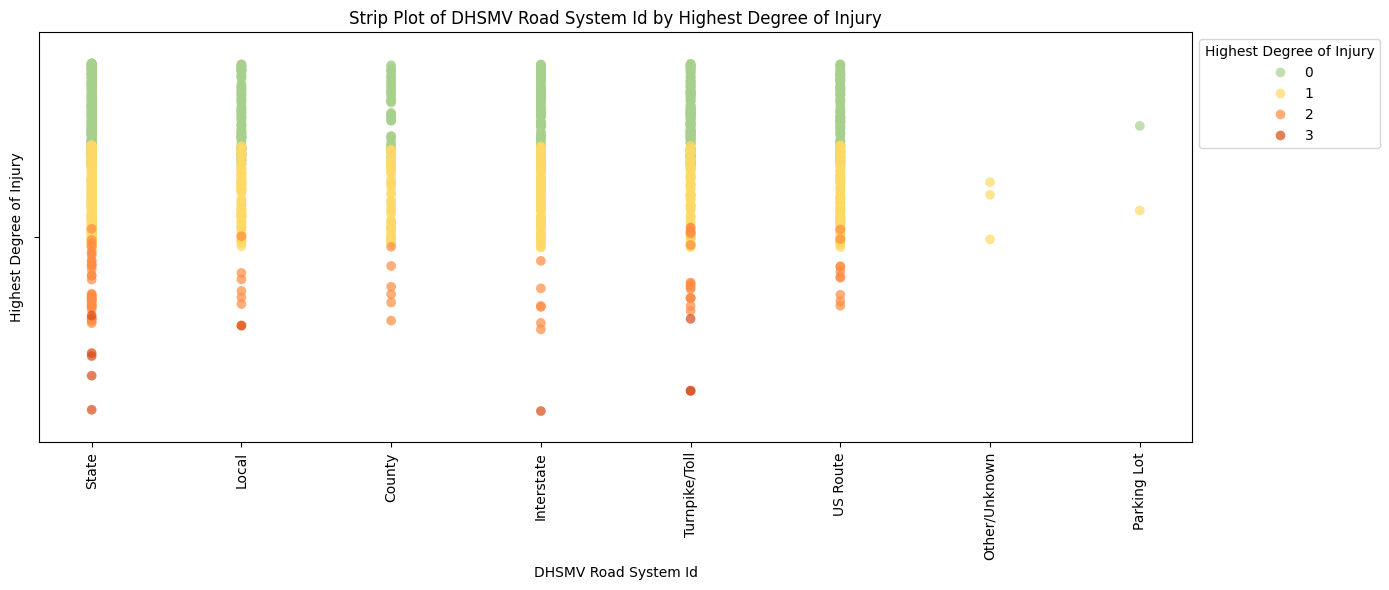

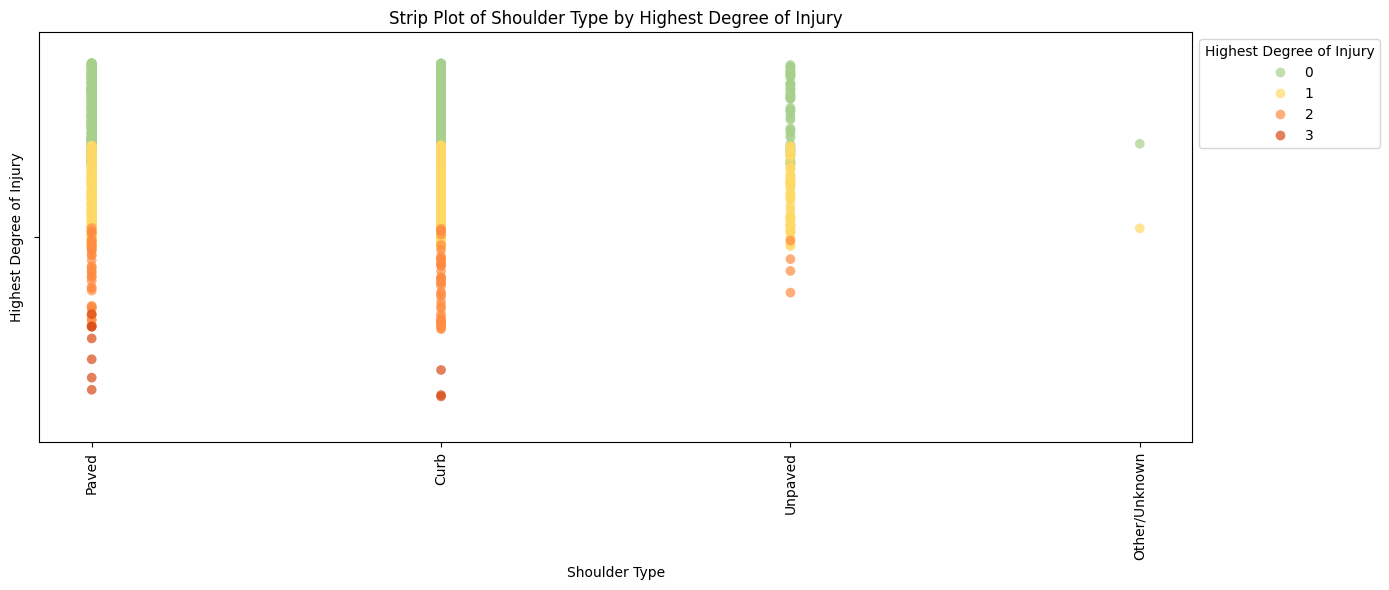

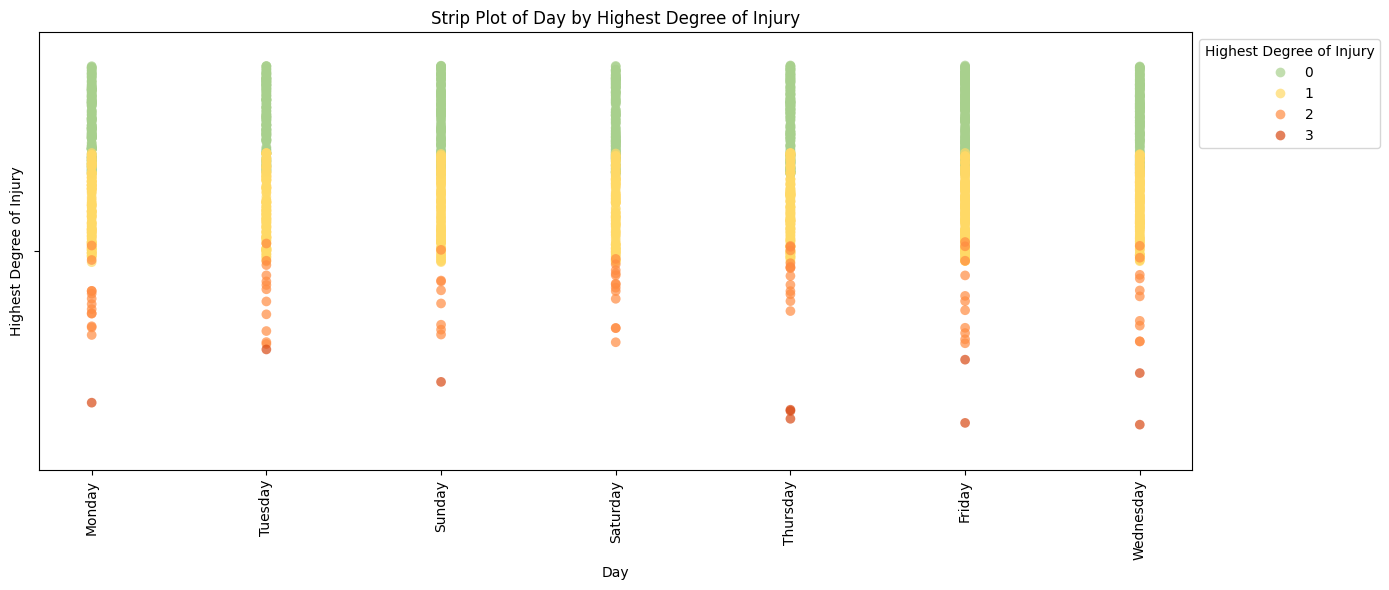

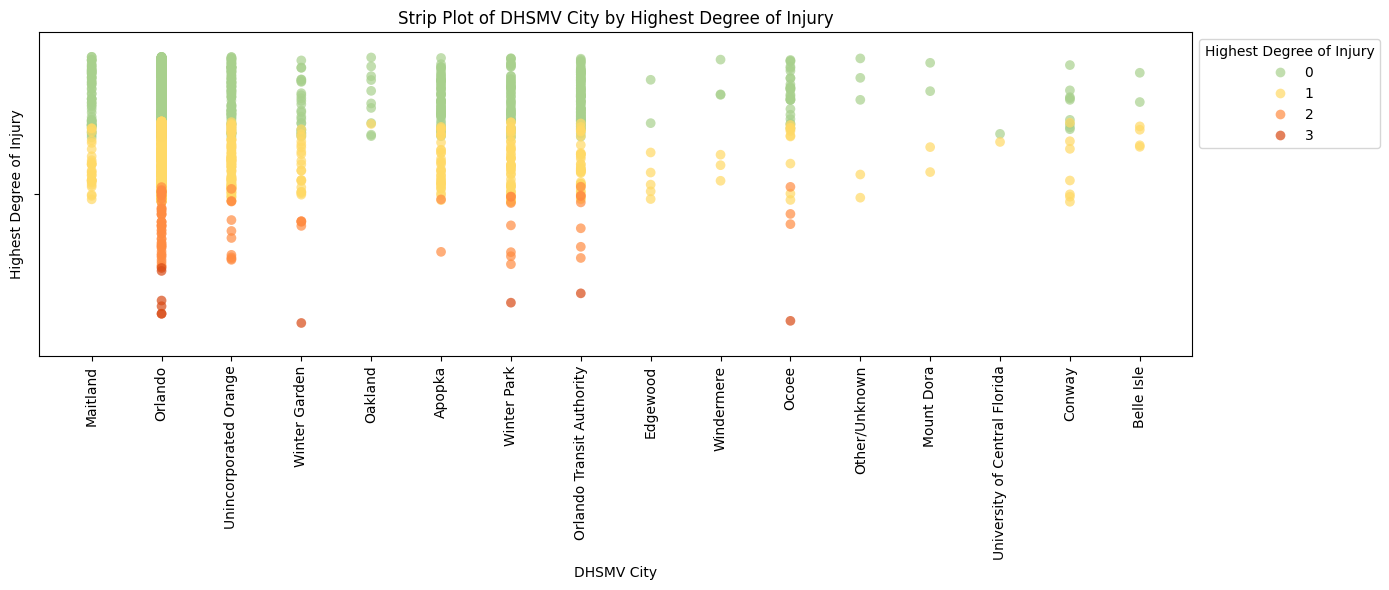

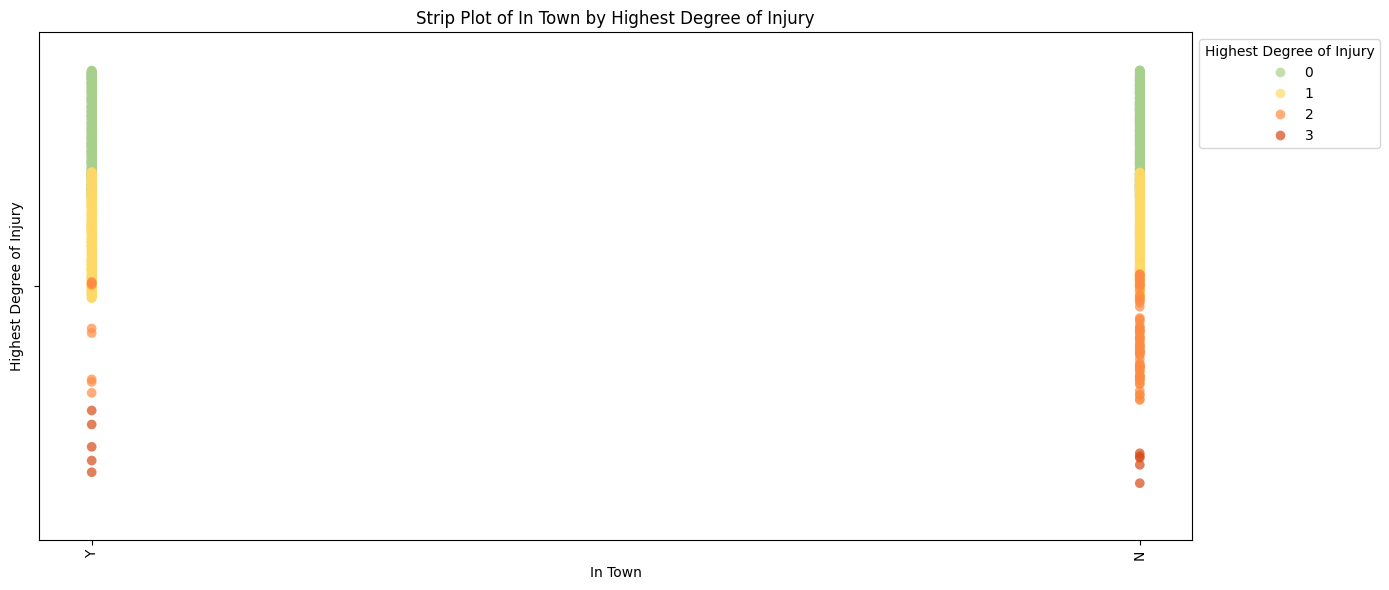

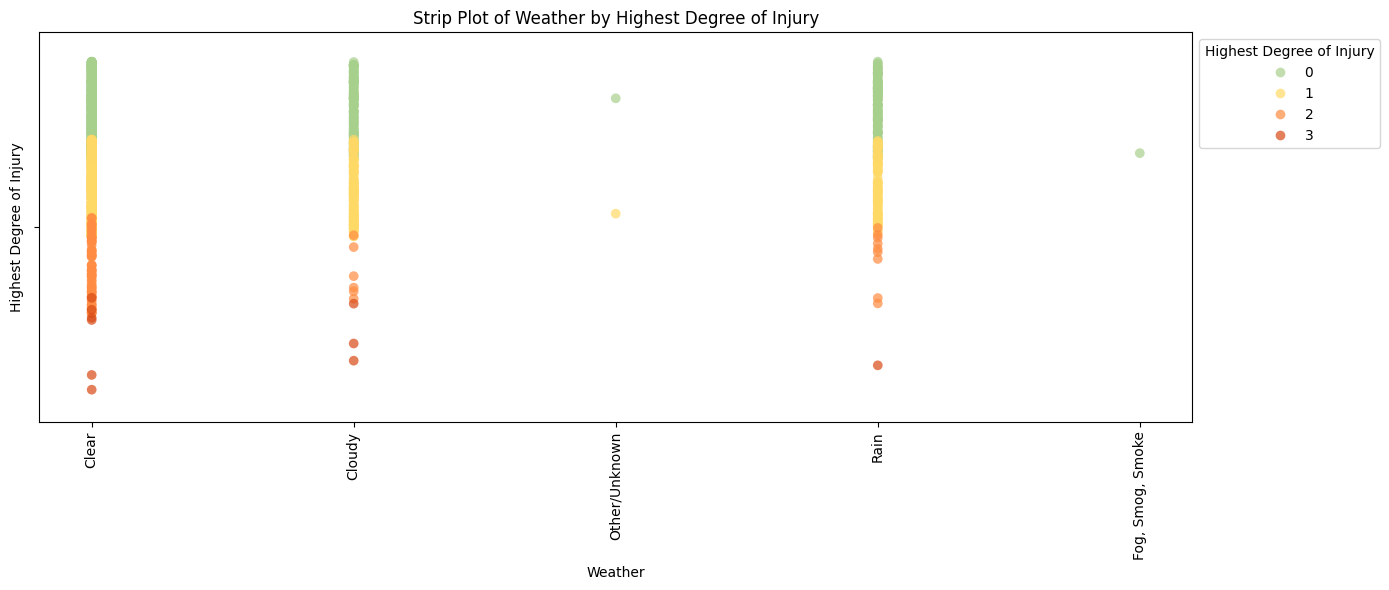

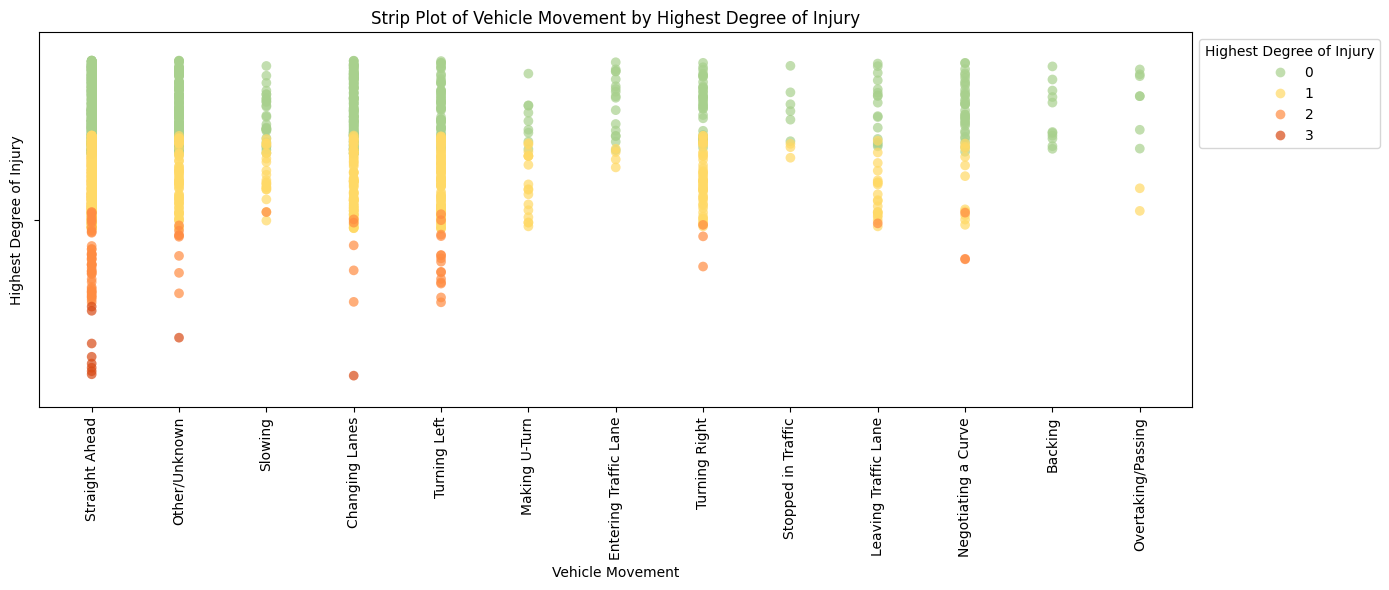

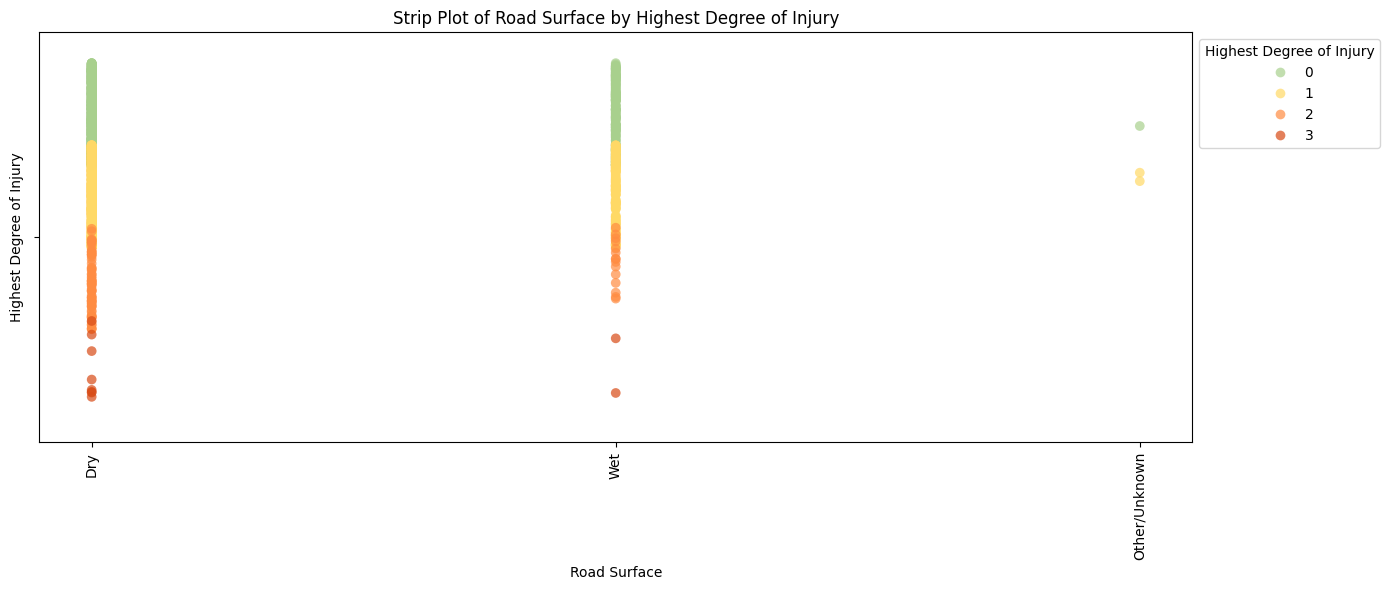

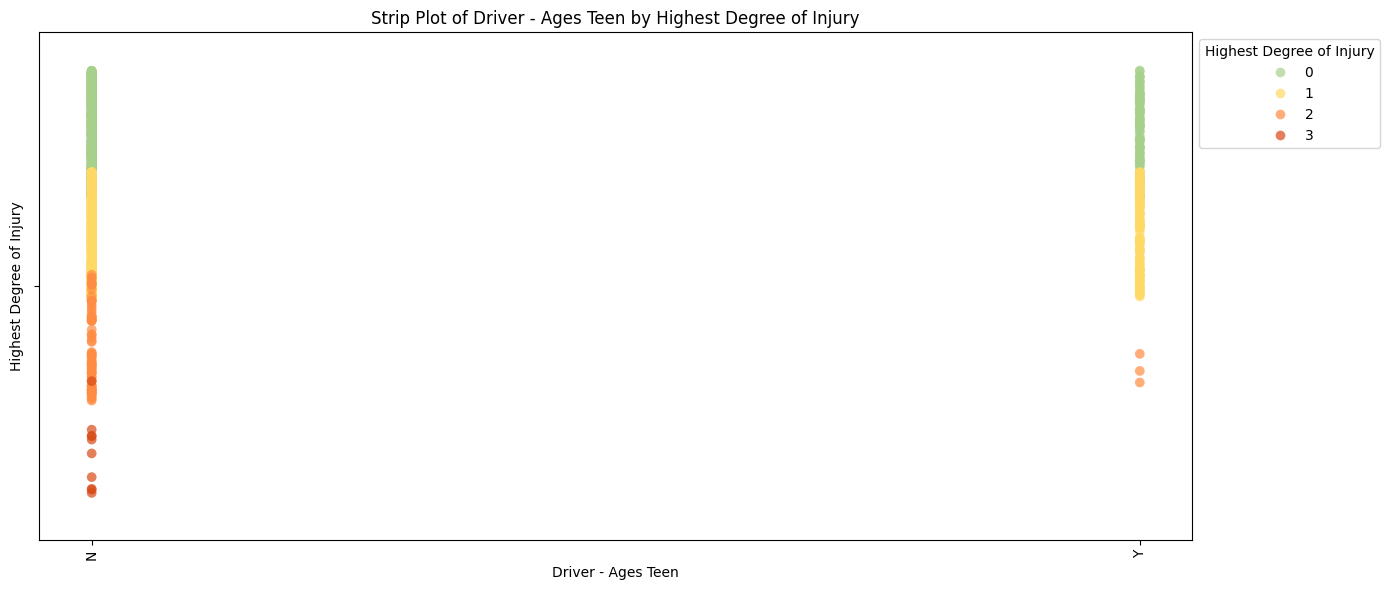

In [ ]:
sample = data_v6.sample(2000)

def plot_by_variable_type(data, X, y, categorical_vars, continuous_vars, discrete_vars, custom_palette):
    for col in X.columns:
        plt.figure(figsize=(14, 6))

        if col in categorical_vars or col in discrete_vars:
            # Create stripplot for categorical or discrete variables
            sns.stripplot(data=sample, x=col, hue=y, palette=custom_palette, size=7, dodge=True, alpha=0.7, jitter=0.5)
            plot_type = "Strip Plot"
        elif col in continuous_vars:
            # Create swarmplot for continuous variables
            sns.swarmplot(data=sample, x=col, hue=y, palette=custom_palette, size=5, dodge=True, alpha=0.7)
            plot_type = "Swarm Plot"

        # Set the titles and legend
        plt.title(f"{plot_type} of {col} by Highest Degree of Injury")
        plt.xlabel(col)
        plt.ylabel("Highest Degree of Injury")
        plt.legend(title='Highest Degree of Injury', bbox_to_anchor=(1, 1), loc='upper left')

        # Rotate labels for continuous vars
        if col in categorical_vars:
            plt.xticks(rotation=90)

        # Show the plot
        plt.tight_layout()
        plt.show()

X = sample[selected_features]  # Input features
y = sample['Highest Degree of Injury']  # Output feature

plot_by_variable_type(data_v6, X, y, categorical_vars, continuous_vars, discrete_vars, custom_palette)

### **Class Distribution**
Is the response variable's severity of injury classes imbalanced?

In [ ]:
y = data_v6['Highest Degree of Injury']
y = pd.DataFrame(y)

counts = []
for i in range(0,4):
    counts.append(y['Highest Degree of Injury'].value_counts()[i])

for i in range(len(counts)):
    print("Count of Injury Severity", str(i) + ":", counts[i])

Count of Injury Severity 0: 6208
Count of Injury Severity 1: 5163
Count of Injury Severity 2: 540
Count of Injury Severity 3: 102


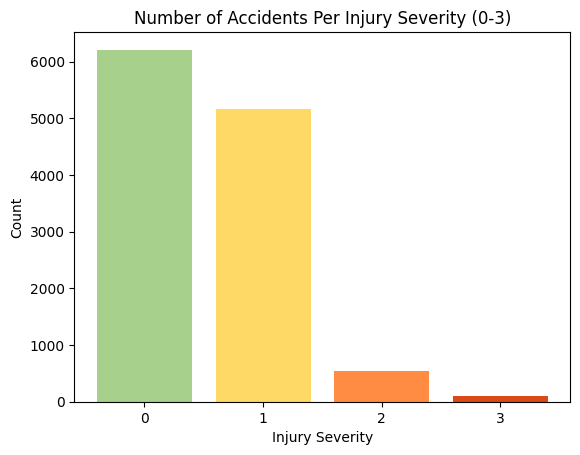

In [ ]:
color = [custom_palette[i] for i in range(len(counts))]
plt.bar(range(4), counts, color = color)
plt.title("Number of Accidents Per Injury Severity (0-3)")
plt.ylabel("Count")
plt.xlabel("Injury Severity")
plt.xticks(range(4), ['0', '1', '2', '3'])
plt.grid(False)
plt.show()

There is a clear imbalance in classes, the higher the severity of injury the fewer the classes, with a sharp drop from 1 (minor injury) to 2 (severe injury).

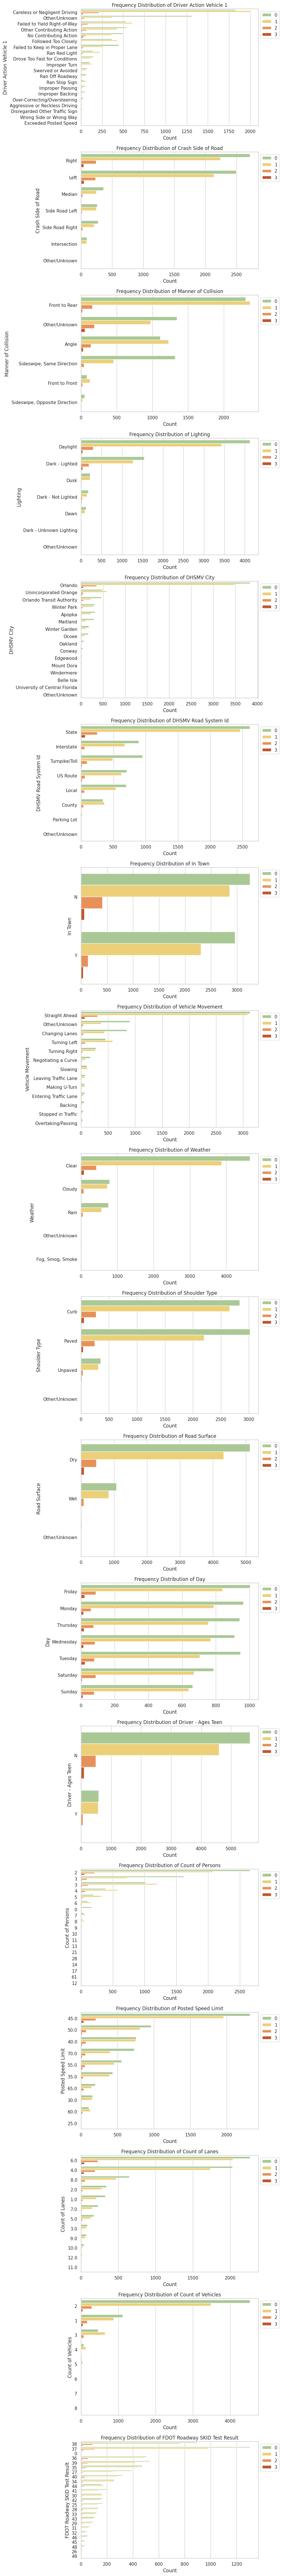

In [ ]:
# Choose columns to plot that are relevant to your analysis
columns_to_plot = categorical_vars + discrete_vars

# Set the aesthetics for seaborn plots
sns.set(style="whitegrid")

# Create a figure to hold the plots with a suitable size
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 5 * len(columns_to_plot)))

# Loop through the columns and create a count plot for each
for i, column in enumerate(columns_to_plot):
    sns.countplot(data=data_v6, y=column, ax=axes[i], hue="Highest Degree of Injury", palette = custom_palette, order=data_v5[column].value_counts().index)
    axes[i].set_title(f'Frequency Distribution of {column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


**Correlation Matrix**

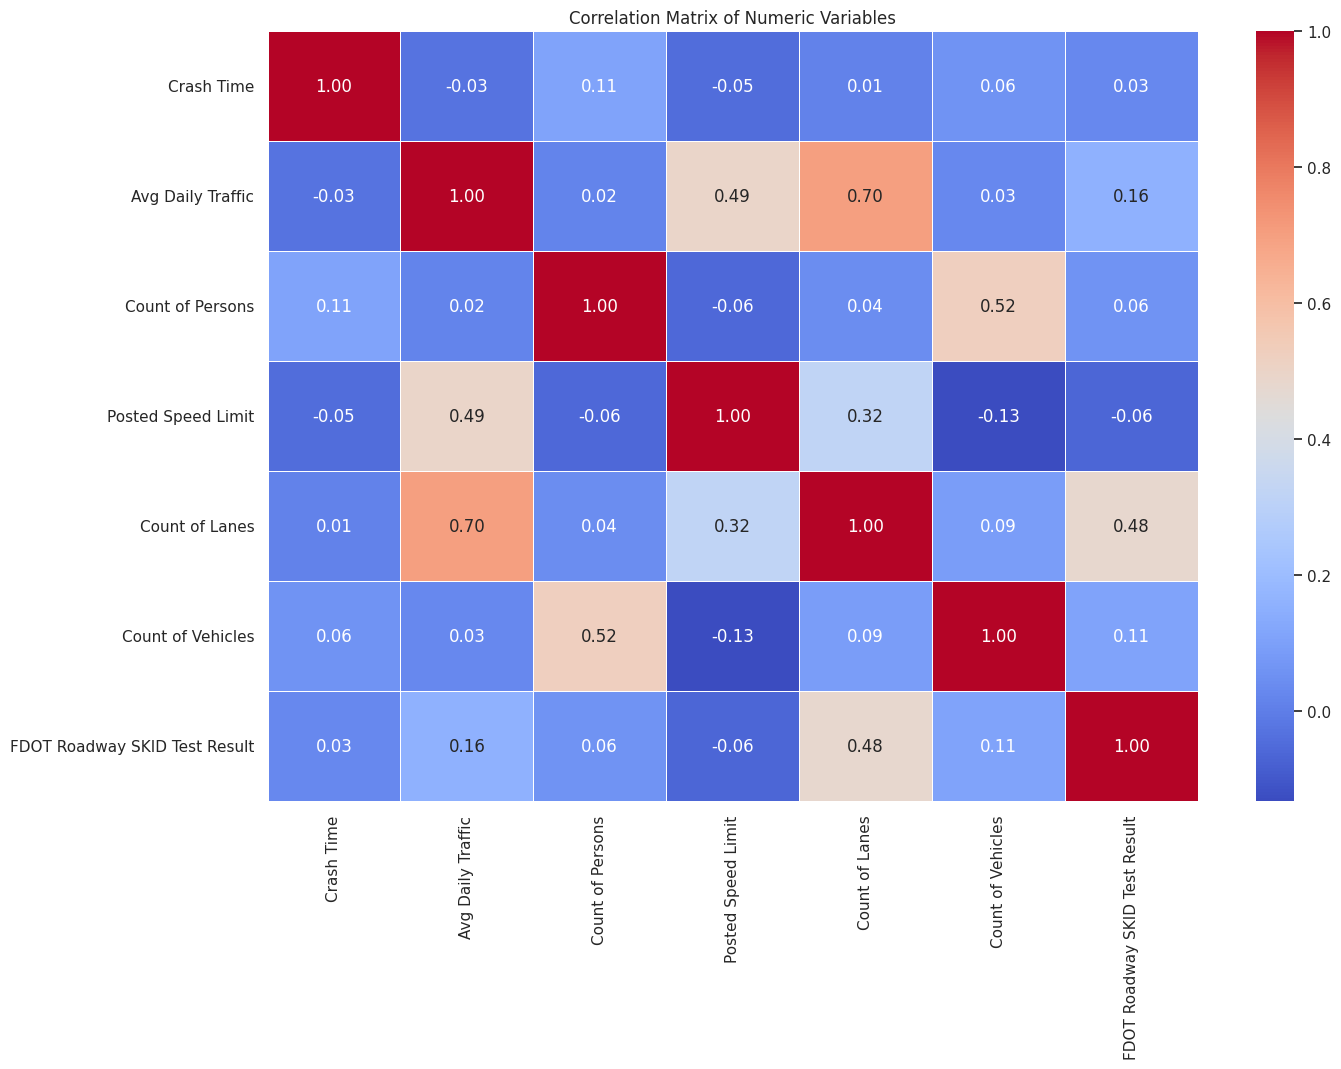

In [ ]:
# Define variables to plot
vars_to_plot = continuous_vars + discrete_vars

# Create a new dataframe with selected columns
data_for_matrix = data_v5[vars_to_plot].copy()

# Compute the correlatioton matrix
corr_matrix = data_for_matrix.corr()

# Plot the matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Set title
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

# Modeling

Here is a basic setup for all of our models, including defining the input and output features, performing a train test split, and prepreprocessing the columns.

In [ ]:
# Use input and output variables from feature selection
X = data_v6[selected_features]
y = data_v6['Highest Degree of Injury']

# Train-test split - stratify=y to ensure minority classes are represented
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# Define transformer to scale numeric vars and encode categorical vars
numeric_vars = continuous_vars + discrete_vars
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_vars),
        ('cat', OneHotEncoder(drop="first", sparse_output=False), categorical_vars)
    ]
)

### Logistic Regression Model

In [ ]:
# Create pipeline to apply preprocessor and apply logistic regression
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train model
lr.fit(X_train, y_train)

# Evaluate model and print accuracy and classification report
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5980024968789014
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.64      0.64      1242
           1       0.55      0.62      0.58      1033
           2       0.00      0.00      0.00       108
           3       0.33      0.05      0.09        20

    accuracy                           0.60      2403
   macro avg       0.38      0.33      0.33      2403
weighted avg       0.57      0.60      0.58      2403



### KNN

In [ ]:
# Create pipeline to apply preprocessor and apply KNeighbors Regressor
knn = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', KNeighborsClassifier(n_neighbors=1))
])

# Find the best number of k neighbors
scores = []
for k in range(1,200):
    knn.set_params(classifier__n_neighbors=k)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    scores.append([k, accuracy_score(y_pred, y_test)])

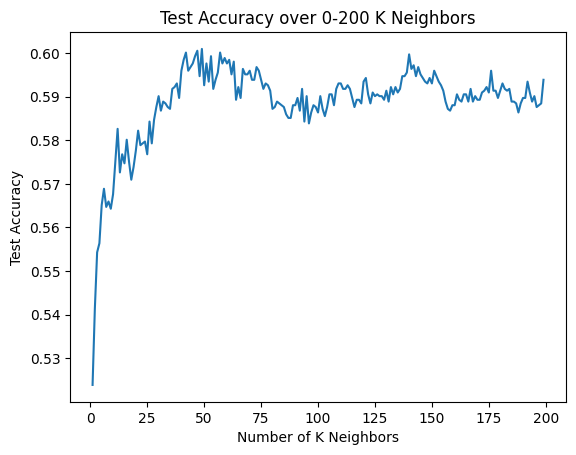

In [ ]:
scores = np.array(scores)
plt.plot(scores[:,0], scores[:,1])
plt.xlabel("Number of K Neighbors")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over 0-200 K Neighbors")
plt.show()

Use K where the Test Accuracy first begins to plateau. Looking at the graph, this seems to be around 30-60.

In [ ]:
scores[scores[:,1] == scores[:65,1].max()]

array([[49.        ,  0.60091552]])

We will go with k = 49 as our best k.

In [ ]:
k = 49
knn.set_params(classifier__n_neighbors = k)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6009155222638368
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.66      1242
           1       0.56      0.56      0.56      1033
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00        20

    accuracy                           0.60      2403
   macro avg       0.30      0.31      0.31      2403
weighted avg       0.57      0.60      0.58      2403



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create pipeline with SMOTE
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train model
lr_pipeline.fit(X_train, y_train)

# Evaluate model
y_pred = lr_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.43154390345401583
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.46      0.55      1242
           1       0.56      0.40      0.47      1033
           2       0.08      0.42      0.13       108
           3       0.05      0.65      0.09        20

    accuracy                           0.43      2403
   macro avg       0.35      0.48      0.31      2403
weighted avg       0.61      0.43      0.49      2403



# **Random Forest Model**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = data_v1.copy()
df = df.dropna(subset=["Count of Traffic Fatalities"])
y = df["Count of Traffic Fatalities"]
X = df.drop(columns=["Count of Traffic Fatalities"])
categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names[:20], importances[:20])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


NameError: name 'data_v1' is not defined